# Lab Six -  Convolutional Network Architectures
Amory Weinzierl, Fidelia Nawar, and Hayden Center

In this lab, you will select a prediction task to perform on your dataset, evaluate a deep learning architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (<b>one per team</b>) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

<b>Dataset Selection</b>

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

## Preparation (3 pts)

- [<b>1.5 points</b>] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a <b>detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate</b> for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [<b>1.5 points</b>] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). <b>Explain why your chosen method is appropriate or use more than one method as appropriate</b>. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
# Importing packages and reading in dataset
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)
print('Tensorflow:', tf.__version__)
print('Keras:',  keras.__version__)

Pandas: 1.1.3
Numpy: 1.19.2
Tensorflow: 2.4.1
Keras: 2.4.0


In [2]:
%%time

#source: https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/
from PIL import Image

#source: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
from pathlib import Path

#directory name
paths = {
    "TRAIN": './Coronahack-Chest-XRay-Dataset/train/',
    "TEST":  './Coronahack-Chest-XRay-Dataset/test/'    
}
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')

h, w = 64, 64

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible

images = metadata[["X_ray_image_name", "Dataset_type"]]
X_data = []
y_data = metadata["Label"]
for idx, img in images.iterrows():
    name = img["X_ray_image_name"]
    path = img["Dataset_type"]
    img_arr = np.asarray(Image.open(paths[path] + name).convert('L').resize((h,w)))
    X_data.append(img_arr)

Wall time: 59.1 s


In [3]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
_X = np.expand_dims(np.array(X_data), axis=-1)/255 - 0.5
_y = le.fit_transform(np.array(y_data))

print(_X.shape, _y.shape)

(5910, 64, 64, 1) (5910,)


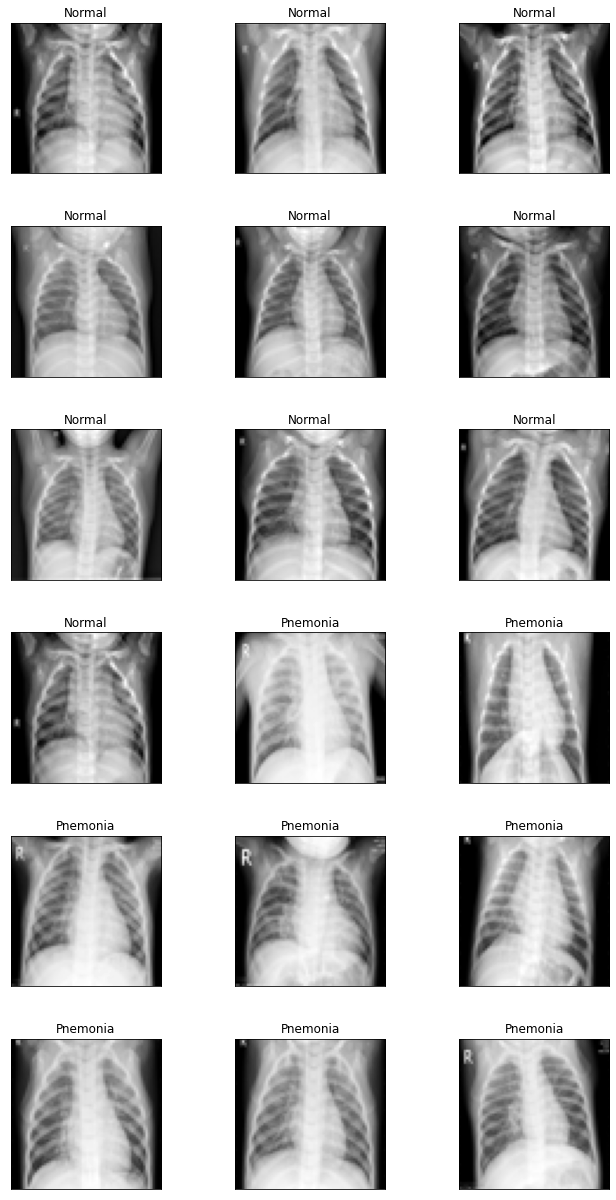

In [4]:
import matplotlib.pyplot as plt

display_imgs = np.concatenate((_X[0:9], _X[-9:]))
labels = np.concatenate((y_data[0:9], y_data[-9:]))
def plot_gallery(images, titles, n_row=3, n_col=3):
    plt.figure(figsize=(n_col * n_col, 6 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    #normal scans tended towards front
    for i in range(n_row * n_col):
        plt.subplot(n_row * 2, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    #pnemonia scans toward back so we pulled some from the back 
    #for demonstration purposes
    for j in range(n_row * n_col):
        plt.subplot(n_row * 2, n_col, n_row * n_col + j + 1)
        plt.imshow(images[-1*j], cmap=plt.cm.gray)
        plt.title(titles[-1*j], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(display_imgs, labels)

#### Evaluation Metric

The primary evaluation metrics we are using for our model are recall and precision. Recall measures the percentage of positive cases that were identified correctly, and precision measures the percentage of positive predictions that were correct.

These metrics emphasizes correct positive identifications, which is applicable to evaluate our solution because we want to minimize the amount of undetected pneumonia lungs, though recall is the more important metric, as it can be used to minimize the false negative rate. Having a low false negative rate is important in this situation because a diagnosis of a "Normal" lung condition when it is in fact penumonia is detrimental and possibly fatal to the patient. On the same token, it's necessary that healthy lungs are not misclassified as pneumonia because that would create unnecessary issues for a healthy patient. Because of this, we chose to use recall and precision, specifically the native Keras implementation of both, to evaluate our CNN solution.

#### Dividing Data

We are using stratified 10-fold cross validation in order to split up the data into training and test sets. We chose to use this method because almost 3/4 of our the lungs in our dataset are labeled as having pneumonia, whereas only 1/4 is labeled as healthy. Thus, if we did a random split/shuffle, there may be disproportionate amounts of pneumonia classification in the training variables, which would make the classification for the testing data less accurate. With 
stratified 10-fold cross validation, we can make a more effective model and also help with generalizing. It allows us to select training and testing sets while also decreasing overall variance because of the 10 folds, which will fit each CNN on each fold. This would be a realistic measuring of a real-world application of the algorithm because with smaller test sets, there is higher variance. Stratified cross validation reduces this variance by averaging over k different partitions, so the performance estimate is less sensitive to the partitioning of the data. We also chose 10 folds because this value has been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.

Additionally, we will be using an 80/20 split, where the 80% test set will be used for cross validation, and then used to train our final models for statistical comparisons of performance on the 20% split, as cross validation does not render a final trained model, and is only useful for comparing our evaluation metrics.

In [5]:
from sklearn.model_selection import train_test_split

X, X_final, y, y_final = train_test_split(_X, _y, test_size=0.2, stratify=_y)

## Modeling (6 pts)

- [<b>1.5 points</b>]  Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
- [<b>2 points</b>] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
- [<b>1.5 points</b>] Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
- [<b>1 points</b>] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

We are using Keras's built in ImageDataGenerator for our data expansion. In reshaping all of our images to 128x128, many of the images were already stretched and squashed in different directions, and so expanding our dataset to stretch and squash them more randomly will hopefully remove any hidden biases that the different image sizes may have created. Additionally, since all of the xrays are more or less similarly oriented, we can add a slight rotational adjustment. However, since the images should all be uniquely oriented horizontally (because the heart is always located to one side of the body) and vertically (all of the images have the patients neck and shoulders on the top side of the image), it would not be useful to flip the images.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.05,
    height_shift_range=0.05)

datagen.fit(X)

In [7]:
from tensorflow.keras.layers       import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers       import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models       import Model, Sequential
from tensorflow.keras.callbacks    import EarlyStopping
from tensorflow.keras.utils        import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

loss = 'binary_crossentropy'
optimizer = 'rmsprop'
metrics = [keras.metrics.Precision(), keras.metrics.Recall()]
batch_size = 128
epochs = 5
verbose = 1
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)
scores = []

In [49]:
def plot_histories(histories):
    plt.figure(figsize=(15,40))
    for fold_no, history in enumerate(histories):
        keys = list(history.history.keys())
        
        plt.subplot(n_splits,3,3*fold_no+1)
        plt.plot(history.history[keys[0]])
        plt.title('Binary Crossentropy')
        plt.ylabel('Fold #'+str(fold_no))

        plt.subplot(n_splits,3,3*fold_no+2)
        plt.plot(history.history[keys[1]])
        plt.title('Precision')
        plt.ylim(0.7, 1)

        plt.subplot(n_splits,3,3*fold_no+3)
        plt.plot(history.history[keys[2]])
        plt.title('Recall')
        plt.ylim(0.7, 1)

### Model 1 - Basic Architecture

In [9]:
def build_basic_model(l2_lambda, metrics):
    reg = l2(l2_lambda)
    cnn = Sequential()

    cnn.add(Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_regularizer=reg,
                padding='same',
                activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu',
                kernel_regularizer=reg))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid',
                kernel_regularizer=reg))

    cnn.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
    
    return cnn

In [10]:
def basic_model(l2_lambda, metrics):
    print("Basic Architecture")
    print("L2 Lambda:", l2_lambda,'\n')

    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = build_basic_model(l2_lambda, metrics)

        print('Fold',fold_no)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=int(len(X_train)/batch_size),
                    epochs=epochs, verbose=verbose)

        print('')
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print(f"Precision:  {round(np.mean(eval_scores[:,1]), 5)}")
    print(f"Recall:     {round(np.mean(eval_scores[:,2]), 5)}")
    
    return histories, eval_scores

#### Variation 1

In [11]:
%%time

histories1, eval_scores1 = basic_model(0.0001, metrics)
scores.append(('basic', 0.0001, eval_scores1))

Basic Architecture
L2 Lambda: 0.0001 

Fold 0

Epoch 1/5
33/33 [==============================] - 23s 650ms/step - loss: 0.7487 - precision: 0.7631 - recall: 0.9092
Epoch 2/5
33/33 [==============================] - 21s 621ms/step - loss: 0.3919 - precision: 0.8692 - recall: 0.9228
Epoch 3/5
33/33 [==============================] - 20s 619ms/step - loss: 0.3108 - precision: 0.9153 - recall: 0.9353
Epoch 4/5
33/33 [==============================] - 20s 617ms/step - loss: 0.2692 - precision: 0.9270 - recall: 0.9401
Epoch 5/5
33/33 [==============================] - 21s 621ms/step - loss: 0.2421 - precision: 0.9360 - recall: 0.9515

15/15 [==============================] - 1s 34ms/step - loss: 0.1852 - precision: 0.9877 - recall: 0.9306
--------------------------------------------------------------------------------------------------------------
Fold 1

Epoch 1/5
33/33 [==============================] - 22s 627ms/step - loss: 0.7085 - precision: 0.7909 - recall: 0.8894
Epoch 2/5
33/33 [==

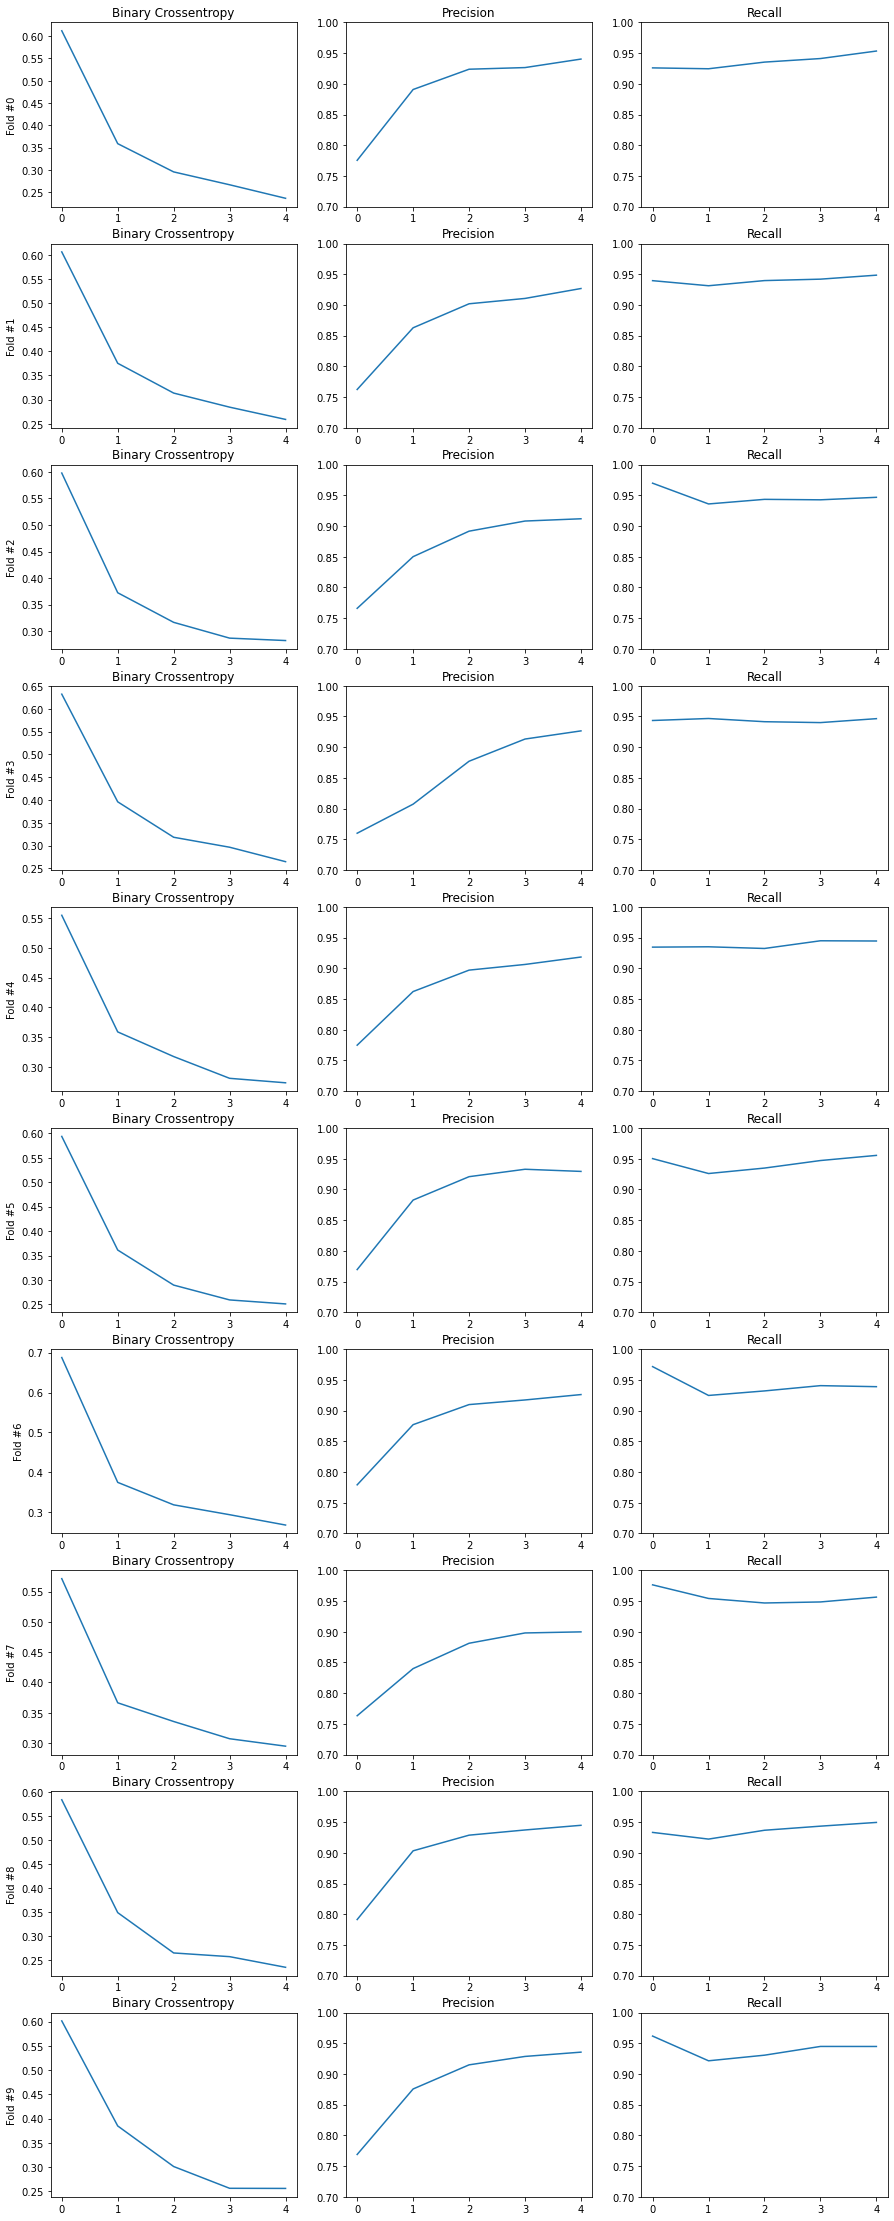

In [12]:
plot_histories(histories1)

#### Variation 2

In [13]:
%%time

histories2, eval_scores2 = basic_model(0.00001, metrics)
scores.append(('basic', 0.00001, eval_scores2))

Basic Architecture
L2 Lambda: 1e-05 

Fold 0

Epoch 1/5
33/33 [==============================] - 21s 586ms/step - loss: 0.6542 - precision: 0.7847 - recall: 0.9307
Epoch 2/5
33/33 [==============================] - 20s 590ms/step - loss: 0.4122 - precision: 0.8263 - recall: 0.9527
Epoch 3/5
33/33 [==============================] - 20s 595ms/step - loss: 0.3211 - precision: 0.8774 - recall: 0.9378
Epoch 4/5
33/33 [==============================] - 20s 594ms/step - loss: 0.2922 - precision: 0.9014 - recall: 0.9373
Epoch 5/5
33/33 [==============================] - 19s 588ms/step - loss: 0.2666 - precision: 0.9134 - recall: 0.9454

15/15 [==============================] - 1s 31ms/step - loss: 0.2265 - precision: 0.9905 - recall: 0.9046
--------------------------------------------------------------------------------------------------------------
Fold 1

Epoch 1/5
33/33 [==============================] - 21s 589ms/step - loss: 0.6335 - precision: 0.7958 - recall: 0.8961
Epoch 2/5
33/33 [===

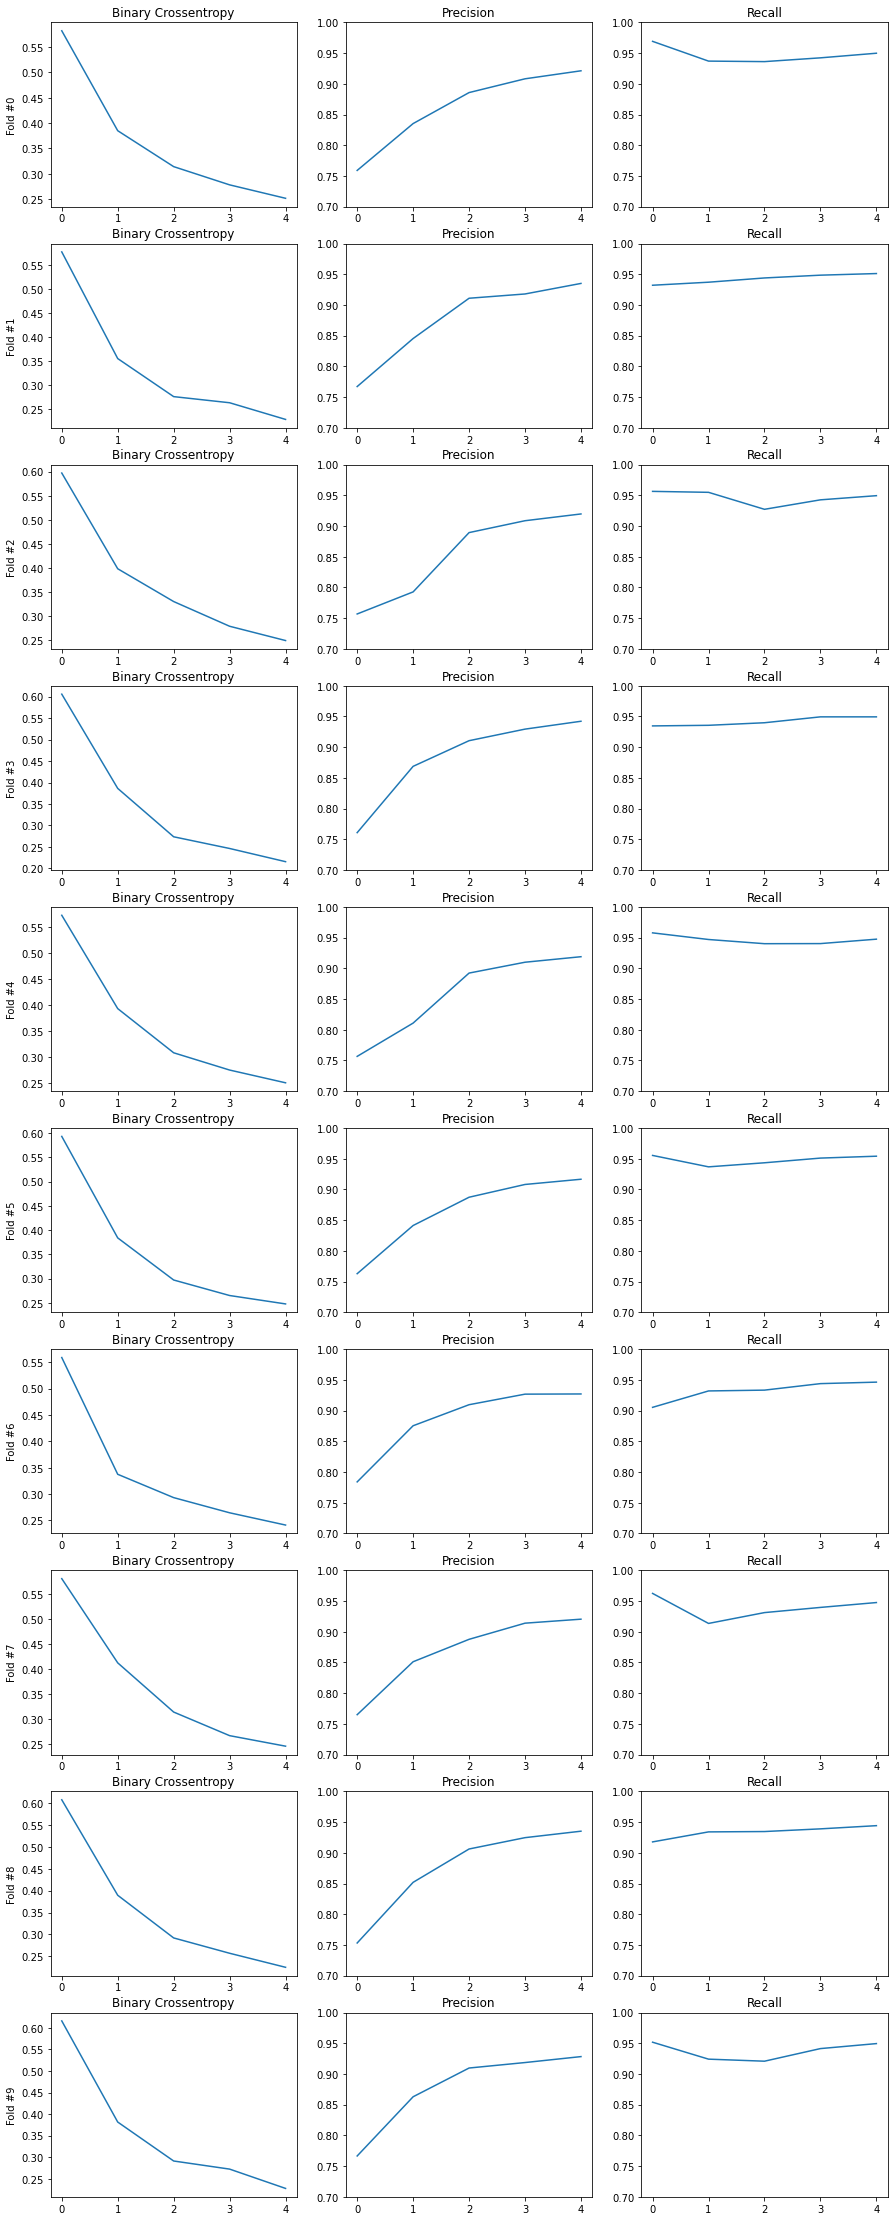

In [14]:
plot_histories(histories2)

#### Variation 3

In [15]:
%%time

histories3, eval_scores3 = basic_model(0.000001, metrics)
scores.append(('basic', 0.000001, eval_scores3))

Basic Architecture
L2 Lambda: 1e-06 

Fold 0

Epoch 1/5
33/33 [==============================] - 21s 620ms/step - loss: 0.6441 - precision: 0.7946 - recall: 0.9565
Epoch 2/5
33/33 [==============================] - 20s 590ms/step - loss: 0.3400 - precision: 0.8718 - recall: 0.9410
Epoch 3/5
33/33 [==============================] - 20s 590ms/step - loss: 0.3404 - precision: 0.8958 - recall: 0.9300
Epoch 4/5
33/33 [==============================] - 20s 596ms/step - loss: 0.2566 - precision: 0.9296 - recall: 0.9332
Epoch 5/5
33/33 [==============================] - 20s 593ms/step - loss: 0.2210 - precision: 0.9370 - recall: 0.9409

15/15 [==============================] - 1s 31ms/step - loss: 0.1403 - precision: 0.9632 - recall: 0.9827
--------------------------------------------------------------------------------------------------------------
Fold 1

Epoch 1/5
33/33 [==============================] - 21s 593ms/step - loss: 0.6336 - precision: 0.7917 - recall: 0.9188
Epoch 2/5
33/33 [===

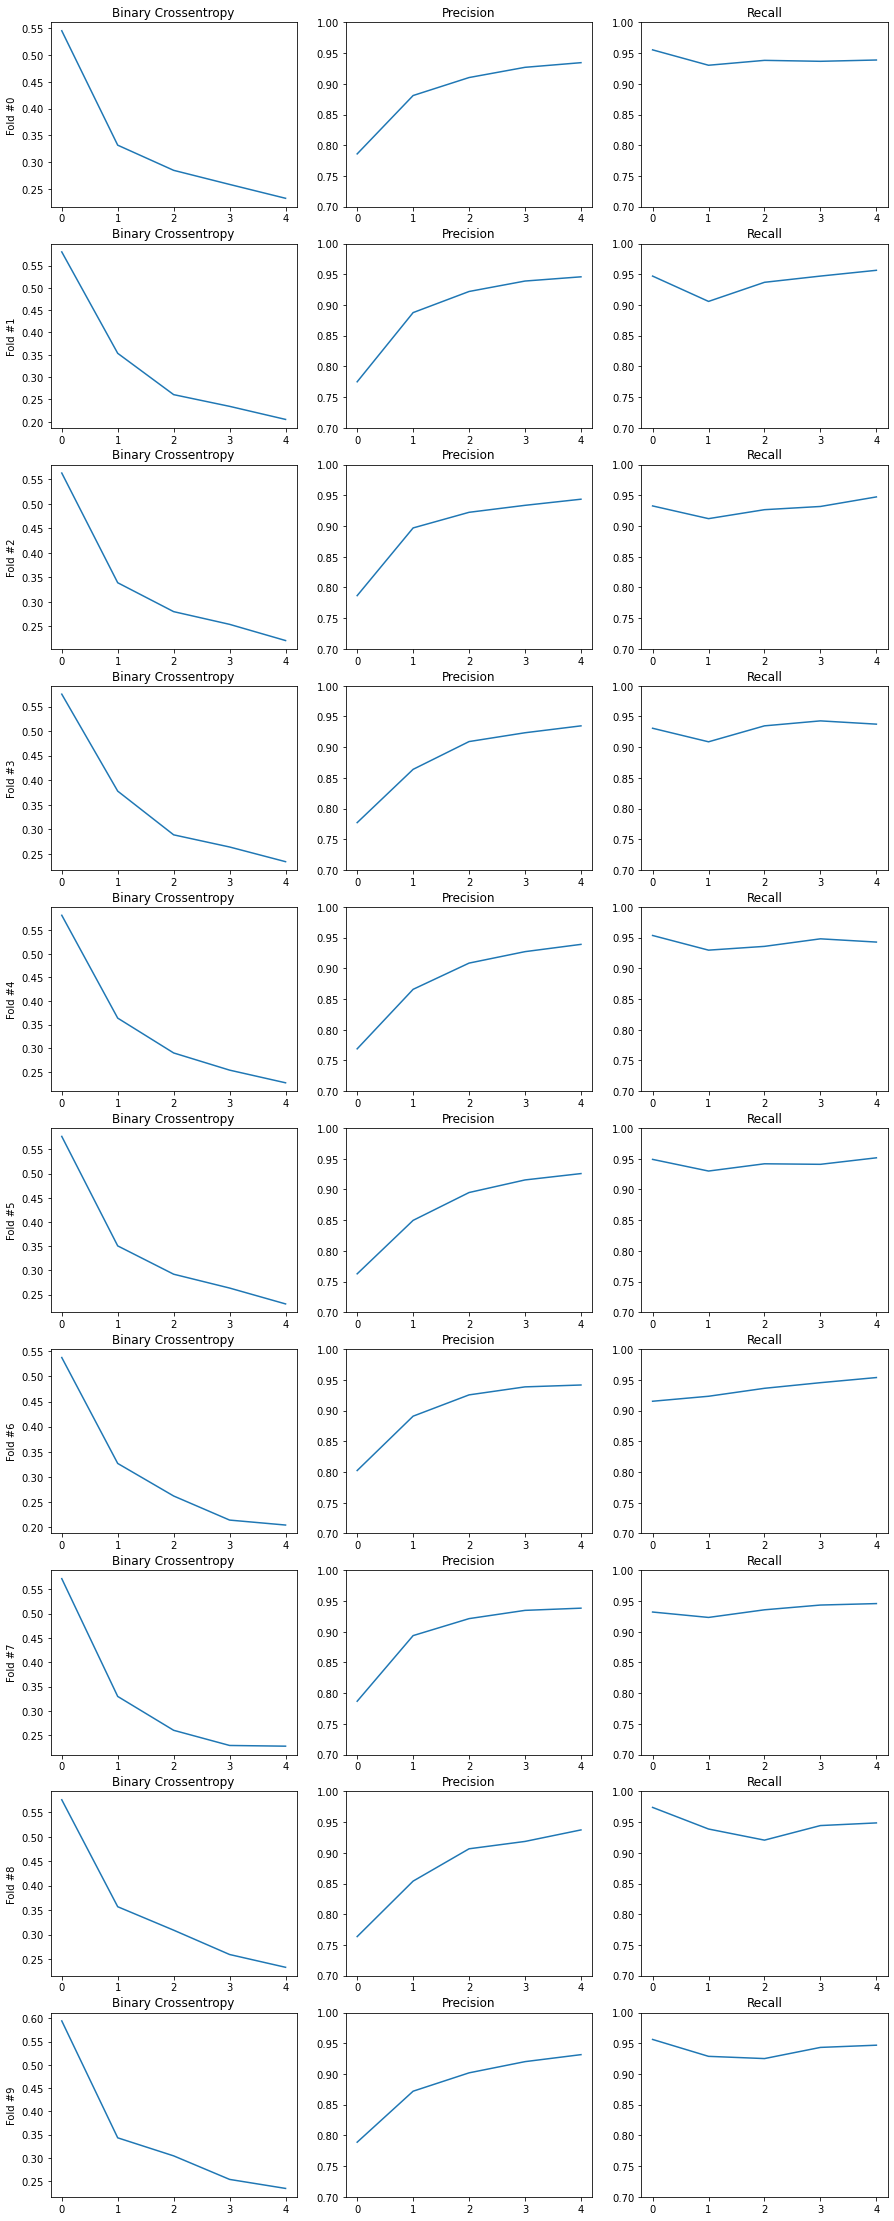

In [16]:
plot_histories(histories3)

### Model 2 - Network in Network Architecture

In [17]:
def build_nin_model(l2_lambda, metrics):
    reg = l2(l2_lambda)
    cnn = Sequential()

    cnn.add(Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))
    cnn.add(Conv2D(filters=1,
                kernel_size=(1,1),
                kernel_regularizer=reg,
                padding='same'))
    cnn.add(Activation('relu'))

    cnn.add(Flatten())
    cnn.add(Dense(1, activation='sigmoid',
                kernel_regularizer=reg))

    cnn.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
    
    return cnn

In [18]:
# Architecture based on https://www.kaggle.com/bingdiaoxiaomao/network-in-network-nin-with-keras

def nin_model(l2_lambda, metrics):
    print("NiN Architecture")
    print("L2 Lambda:", l2_lambda,'\n')

    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = build_nin_model(l2_lambda, metrics)

        print('Fold',fold_no)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=int(len(X_train)/batch_size),
                    epochs=epochs, verbose=verbose)

        print('')
        scores = cnn.evaluate(X_test,y_test, verbose=verbose)
        print('-' * 110)
        
        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print(f"Precision:  {round(np.mean(eval_scores[:,1]), 5)}")
    print(f"Recall:     {round(np.mean(eval_scores[:,2]), 5)}")
    
    return histories, eval_scores

In [19]:
%%time

histories4, eval_scores4 = nin_model(0.0001, metrics)
scores.append(('nin', 0.0001, eval_scores4))

NiN Architecture
L2 Lambda: 0.0001 

Fold 0

Epoch 1/5
33/33 [==============================] - 20s 513ms/step - loss: 0.6484 - precision: 0.7655 - recall: 0.9641
Epoch 2/5
33/33 [==============================] - 17s 509ms/step - loss: 0.4698 - precision: 0.8267 - recall: 0.9457
Epoch 3/5
33/33 [==============================] - 17s 499ms/step - loss: 0.3856 - precision: 0.8850 - recall: 0.9126
Epoch 4/5
33/33 [==============================] - 17s 505ms/step - loss: 0.3627 - precision: 0.8995 - recall: 0.9052
Epoch 5/5
33/33 [==============================] - 16s 496ms/step - loss: 0.3160 - precision: 0.9000 - recall: 0.9353

15/15 [==============================] - 1s 33ms/step - loss: 0.3577 - precision: 0.9437 - recall: 0.8237
--------------------------------------------------------------------------------------------------------------
Fold 1

Epoch 1/5
33/33 [==============================] - 18s 501ms/step - loss: 0.6502 - precision: 0.7757 - recall: 0.9338
Epoch 2/5
33/33 [====

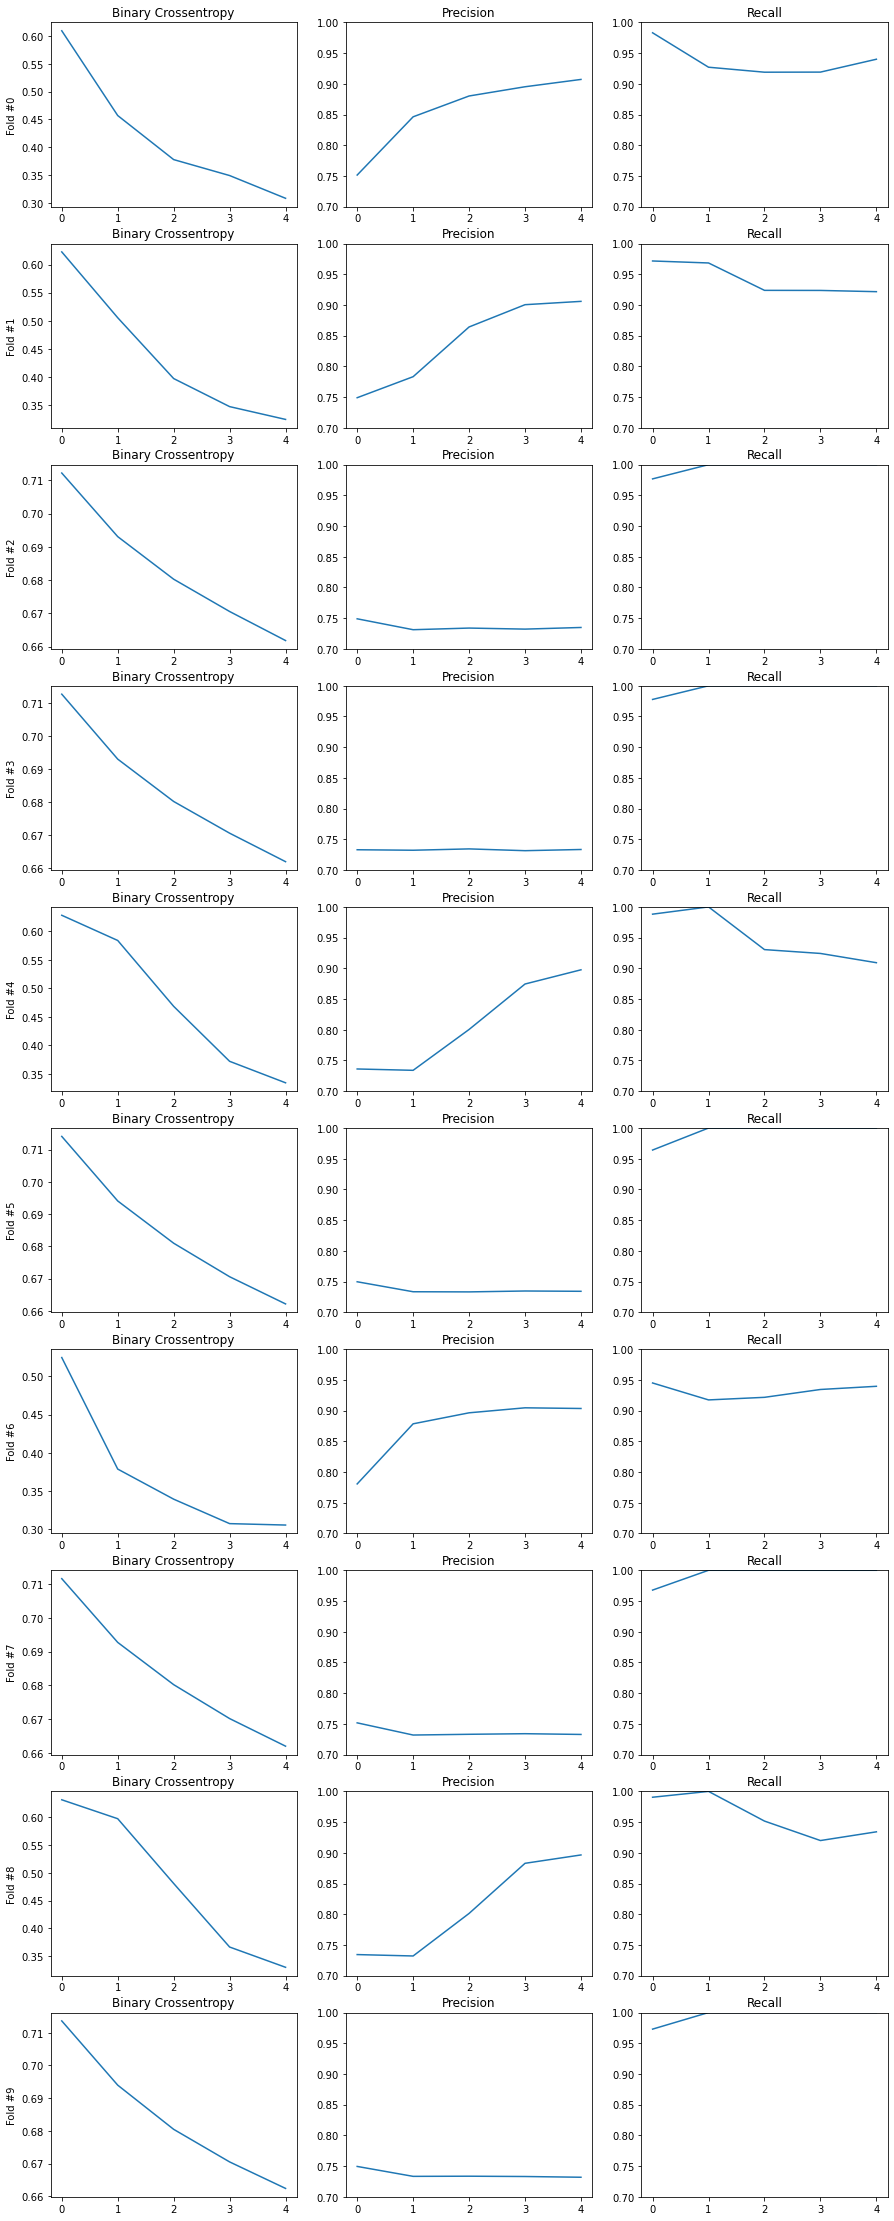

In [20]:
plot_histories(histories4)

In [21]:
%%time

histories5, eval_scores5 = nin_model(0.00001, metrics)
scores.append(('nin', 0.00001, eval_scores5))

NiN Architecture
L2 Lambda: 1e-05 

Fold 0

Epoch 1/5
33/33 [==============================] - 18s 497ms/step - loss: 0.5987 - precision: 0.7368 - recall: 0.9623
Epoch 2/5
33/33 [==============================] - 16s 497ms/step - loss: 0.3673 - precision: 0.8756 - recall: 0.9295
Epoch 3/5
33/33 [==============================] - 16s 494ms/step - loss: 0.3085 - precision: 0.9003 - recall: 0.9239
Epoch 4/5
33/33 [==============================] - 16s 493ms/step - loss: 0.2736 - precision: 0.9176 - recall: 0.9394
Epoch 5/5
33/33 [==============================] - 17s 502ms/step - loss: 0.2601 - precision: 0.9201 - recall: 0.9382

15/15 [==============================] - 1s 30ms/step - loss: 0.1516 - precision: 0.9598 - recall: 0.9653
--------------------------------------------------------------------------------------------------------------
Fold 1

Epoch 1/5
33/33 [==============================] - 18s 497ms/step - loss: 0.6281 - precision: 0.7764 - recall: 0.9566
Epoch 2/5
33/33 [=====

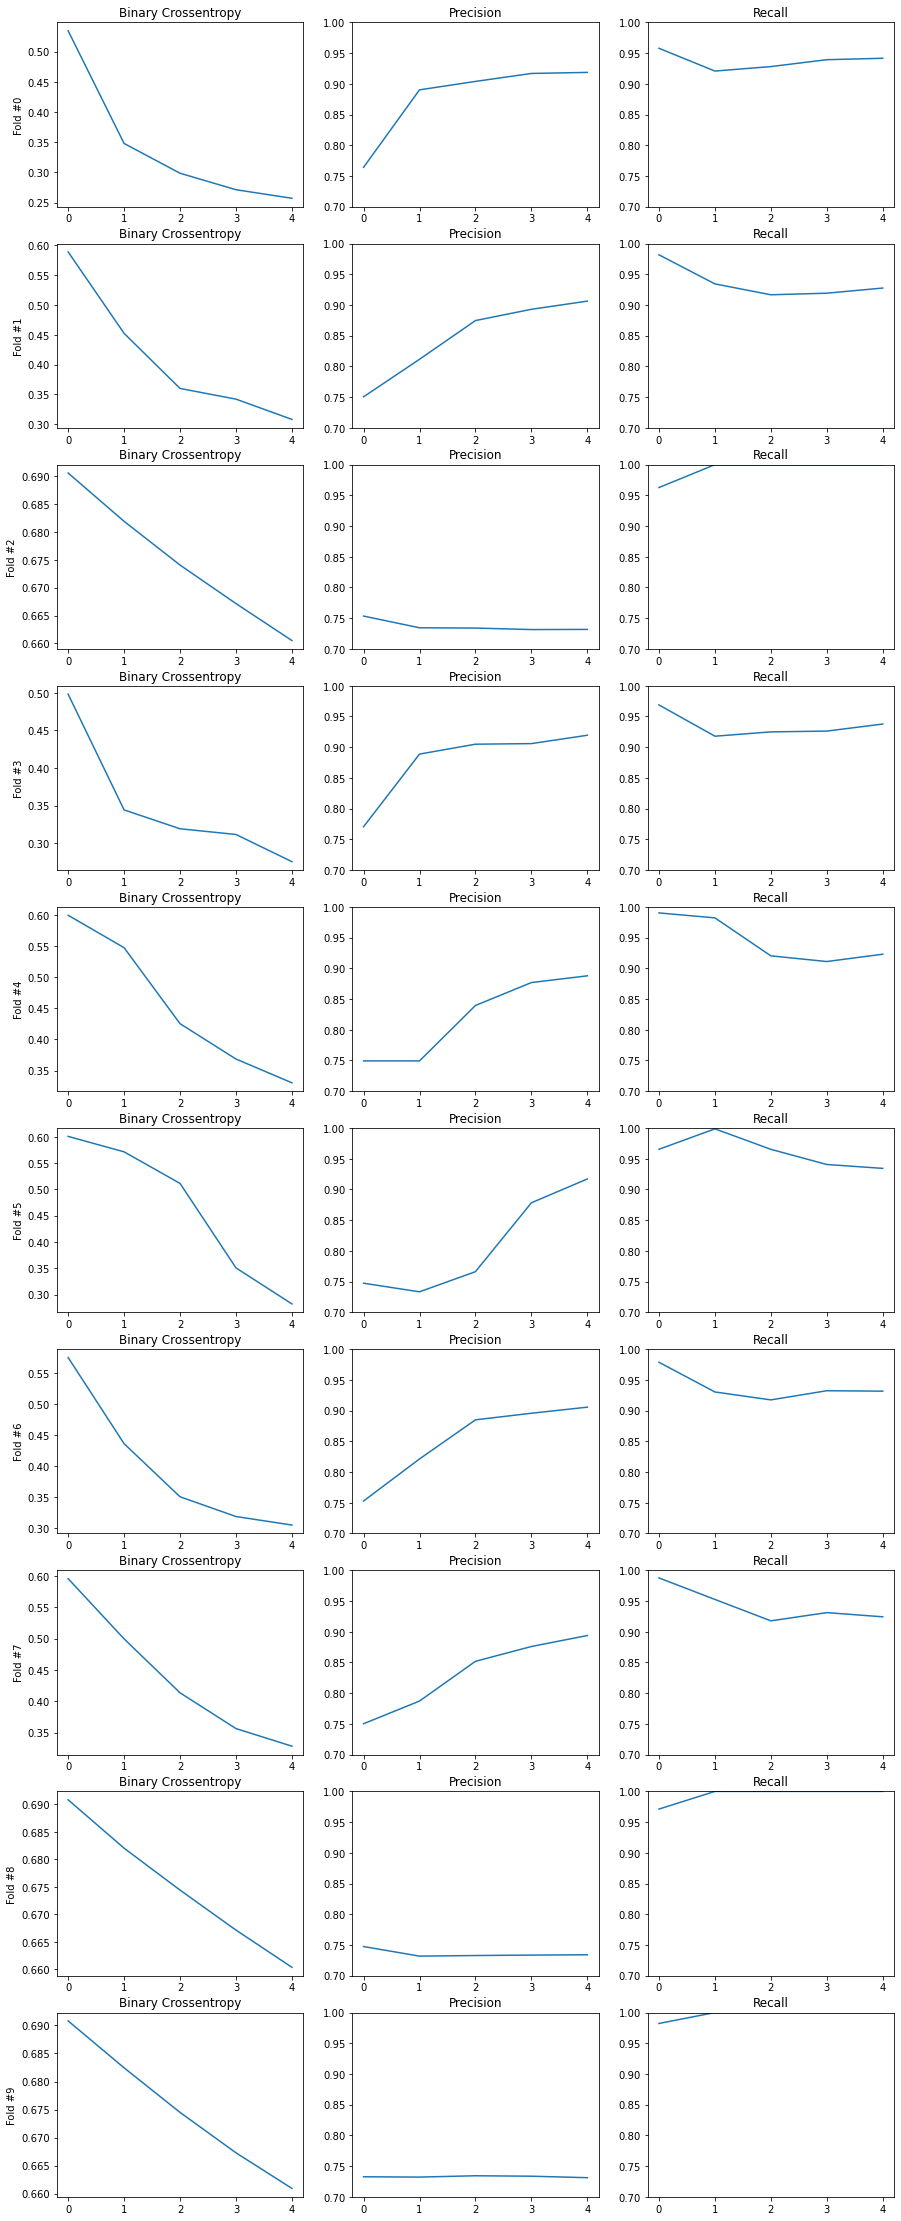

In [22]:
plot_histories(histories5)

In [26]:
%%time

histories6, eval_scores6 = nin_model(0.000001, metrics)
scores.append(('nin', 0.000001, eval_scores6))

NiN Architecture
L2 Lambda: 1e-06 

Fold 0

Epoch 1/5
33/33 [==============================] - 19s 519ms/step - loss: 0.6901 - precision: 0.7721 - recall: 0.9540
Epoch 2/5
33/33 [==============================] - 16s 496ms/step - loss: 0.6819 - precision: 0.7381 - recall: 1.0000
Epoch 3/5
33/33 [==============================] - 17s 500ms/step - loss: 0.6750 - precision: 0.7333 - recall: 1.0000
Epoch 4/5
33/33 [==============================] - 17s 500ms/step - loss: 0.6694 - precision: 0.7221 - recall: 1.0000
Epoch 5/5
33/33 [==============================] - 16s 494ms/step - loss: 0.6625 - precision: 0.7282 - recall: 1.0000

15/15 [==============================] - 1s 31ms/step - loss: 0.6574 - precision: 0.7315 - recall: 1.0000
--------------------------------------------------------------------------------------------------------------
Fold 1

Epoch 1/5
33/33 [==============================] - 18s 493ms/step - loss: 0.6904 - precision: 0.7288 - recall: 0.9525
Epoch 2/5
33/33 [=====

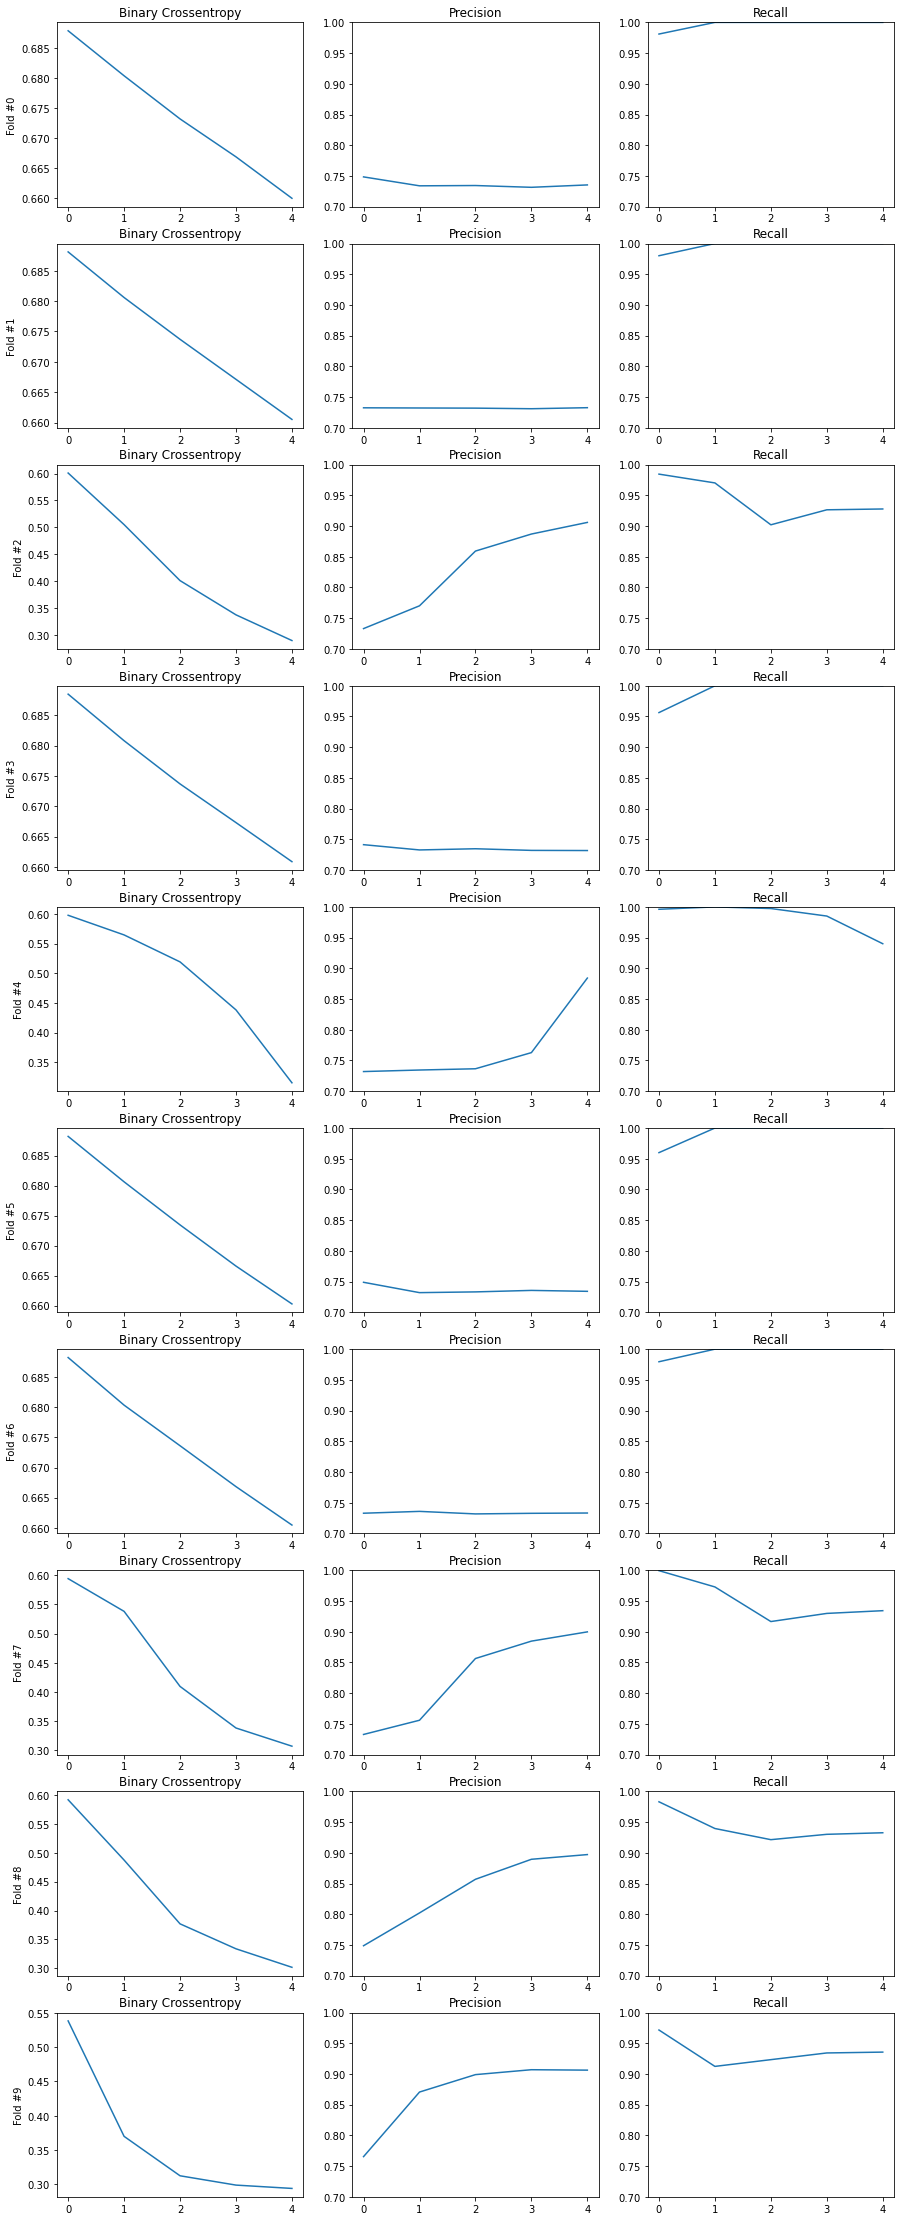

In [50]:
plot_histories(histories6)

### Comparing Models

In [103]:
def plot_histories2(fold_no, histories, labels, dimensions = (15,40)):
    plt.figure(figsize=dimensions)
    for hist, label in zip(histories, labels):
        for fold, history in zip(fold_no, hist):
            keys = list(history.history.keys())
            
            plt.subplot(n_splits,3,3*fold+1)
            plt.plot(history.history[keys[0]], label = label)
            plt.title('Binary Crossentropy')
            plt.ylabel('Fold #'+str(fold))
            plt.legend()
            
            plt.subplot(n_splits,3,3*fold+2)
            plt.plot(history.history[keys[1]], label = label)
            plt.title('Precision')
            plt.ylim(0.7, 1)
            plt.legend()

            plt.subplot(n_splits,3,3*fold+3)
            plt.plot(history.history[keys[2]],label = label )
            plt.title('Recall')
            plt.ylim(0.7, 1)
            plt.legend()

<ipython-input-103-a551b930b006>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_splits,3,3*fold+1)
<ipython-input-103-a551b930b006>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_splits,3,3*fold+2)
<ipython-input-103-a551b930b006>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance

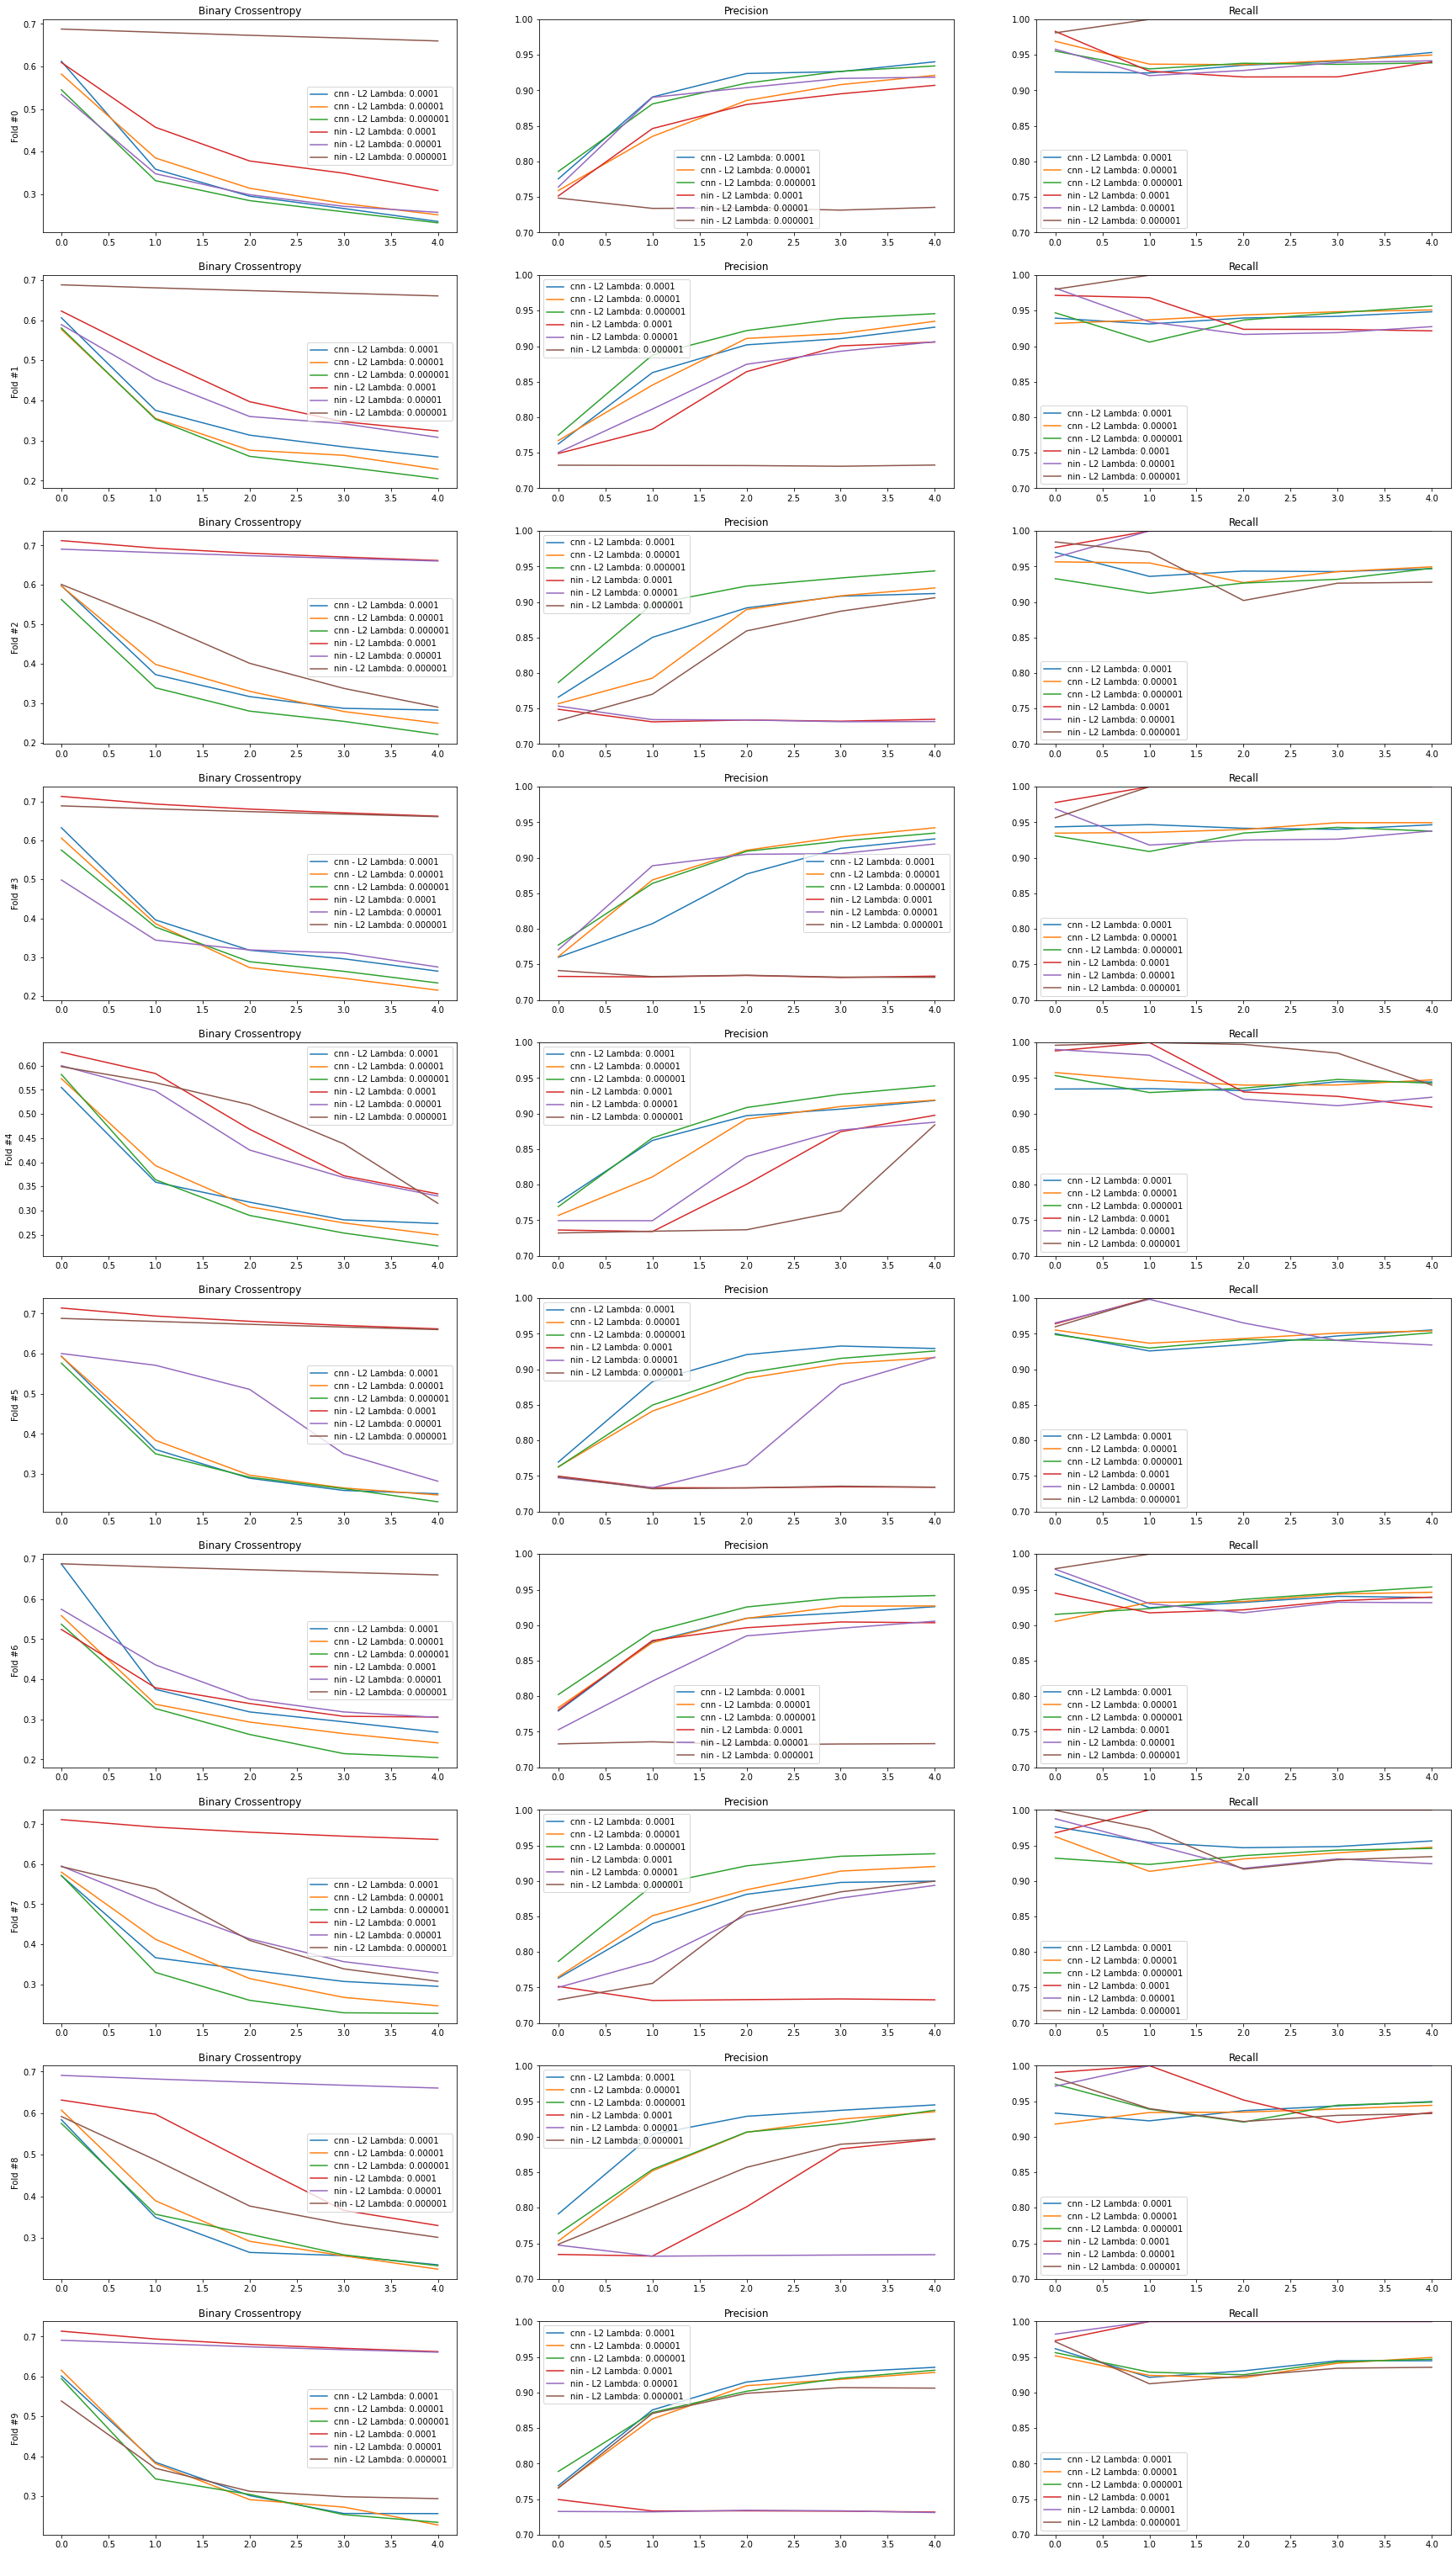

In [118]:
plot_histories2([0,1,2,3,4,5,6,7,8,9], [histories1, histories2, histories3, histories4, histories5, histories6], ['cnn - L2 Lambda: 0.0001', 'cnn - L2 Lambda: 0.00001','cnn - L2 Lambda: 0.000001','nin - L2 Lambda: 0.0001','nin - L2 Lambda: 0.00001','nin - L2 Lambda: 0.000001',], dimensions = (30, 55))

### Explanation of Comparison of Models

## McNemar Test for Models

In [129]:
from statsmodels.stats.contingency_tables import mcnemar



### Explanation of McNemar Test Results for Models

## Implementation of MLP

In [134]:
def build_mlp(l2_lambda, metrics):
    reg = l2(l2_lambda)
    
    mlp = Sequential()
    mlp.add( Dropout(0.25))
    mlp.add( Flatten() )
    mlp.add( Dense(input_dim=images.shape[1], units=100, activation='relu', kernel_regularizer= reg) )
    mlp.add( Dropout(0.5))
    mlp.add( Dense(units=50, activation='relu', kernel_regularizer= reg) )
    mlp.add( Dense(units=50, activation='relu', kernel_regularizer= reg) )
    mlp.add( Dense(1) )
    mlp.add( Activation('sigmoid') )

    mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision', 'Recall'])
    
    return mlp

In [135]:
def mlp(l2_lambda, metrics):
    print("MLP")
    print("L2 Lambda:", l2_lambda, '\n')
    
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        mlp = build_mlp(l2_lambda, metrics)

        print('Fold',fold_no)
        print('')
        
        history = mlp.fit(X_train, y_train, batch_size=32, epochs=5, shuffle=True, verbose=1, 
                          callbacks = [EarlyStopping(monitor='loss', patience=8)], 
                          validation_data=(X_final,y_final))

        print('')
        scores = mlp.evaluate(X_test,y_test, verbose=verbose)
        print('-' * 110)
        
        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print(f"Precision:  {round(np.mean(eval_scores[:,1]), 5)}")
    print(f"Recall:     {round(np.mean(eval_scores[:,2]), 5)}")
    
    return histories, eval_scores

In [121]:
%%time

histories7, eval_scores7 = mlp(0.0001, metrics)
scores.append(('mlp', 0.0001, eval_scores7))

MLP
L2 Lambda: 0.0001 

Fold 0

Epoch 1/5
133/133 [==============================] - 2s 9ms/step - loss: 0.4023 - precision: 0.8517 - recall: 0.9168 - val_loss: 0.2535 - val_precision: 0.9728 - val_recall: 0.9077
Epoch 2/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2558 - precision: 0.9388 - recall: 0.9328 - val_loss: 0.2307 - val_precision: 0.9177 - val_recall: 0.9781
Epoch 3/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2430 - precision: 0.9325 - recall: 0.9548 - val_loss: 0.2272 - val_precision: 0.9364 - val_recall: 0.9677
Epoch 4/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2022 - precision: 0.9469 - recall: 0.9641 - val_loss: 0.2048 - val_precision: 0.9374 - val_recall: 0.9666
Epoch 5/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2231 - precision: 0.9403 - recall: 0.9588 - val_loss: 0.2008 - val_precision: 0.9517 - val_recall: 0.9539

15/15 [==============================] - 0s 2ms/step - loss: 0

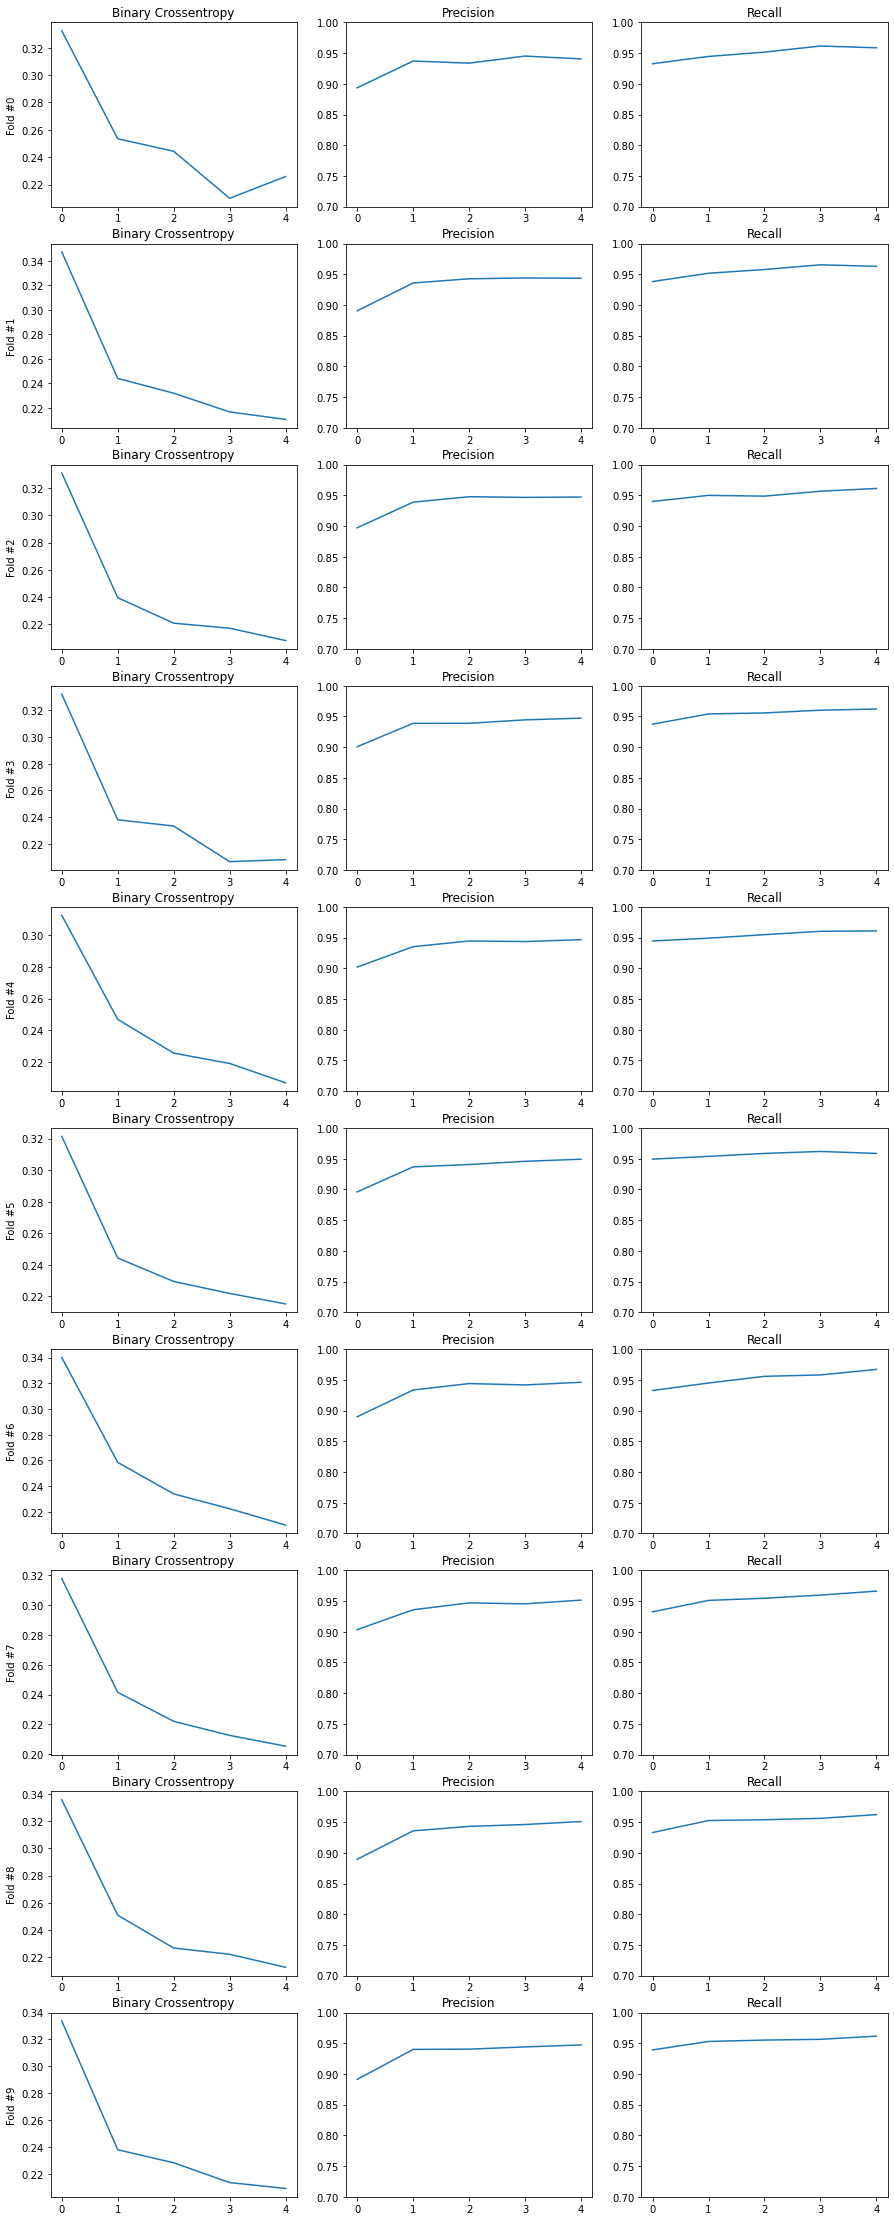

In [122]:
plot_histories(histories7)

In [123]:
histories8, eval_scores8 = mlp(0.00001, metrics)
scores.append(('mlp', 0.00001, eval_scores8))

MLP
L2 Lambda: 1e-05 

Fold 0

Epoch 1/5
133/133 [==============================] - 2s 8ms/step - loss: 0.3798 - precision: 0.8529 - recall: 0.9224 - val_loss: 0.1915 - val_precision: 0.9537 - val_recall: 0.9504
Epoch 2/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2260 - precision: 0.9428 - recall: 0.9427 - val_loss: 0.2009 - val_precision: 0.9243 - val_recall: 0.9723
Epoch 3/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2067 - precision: 0.9326 - recall: 0.9549 - val_loss: 0.1854 - val_precision: 0.9405 - val_recall: 0.9666
Epoch 4/5
133/133 [==============================] - 1s 6ms/step - loss: 0.1851 - precision: 0.9446 - recall: 0.9636 - val_loss: 0.1921 - val_precision: 0.9291 - val_recall: 0.9827
Epoch 5/5
133/133 [==============================] - 1s 6ms/step - loss: 0.1948 - precision: 0.9433 - recall: 0.9599 - val_loss: 0.1780 - val_precision: 0.9478 - val_recall: 0.9631

15/15 [==============================] - 0s 2ms/step - loss: 0.

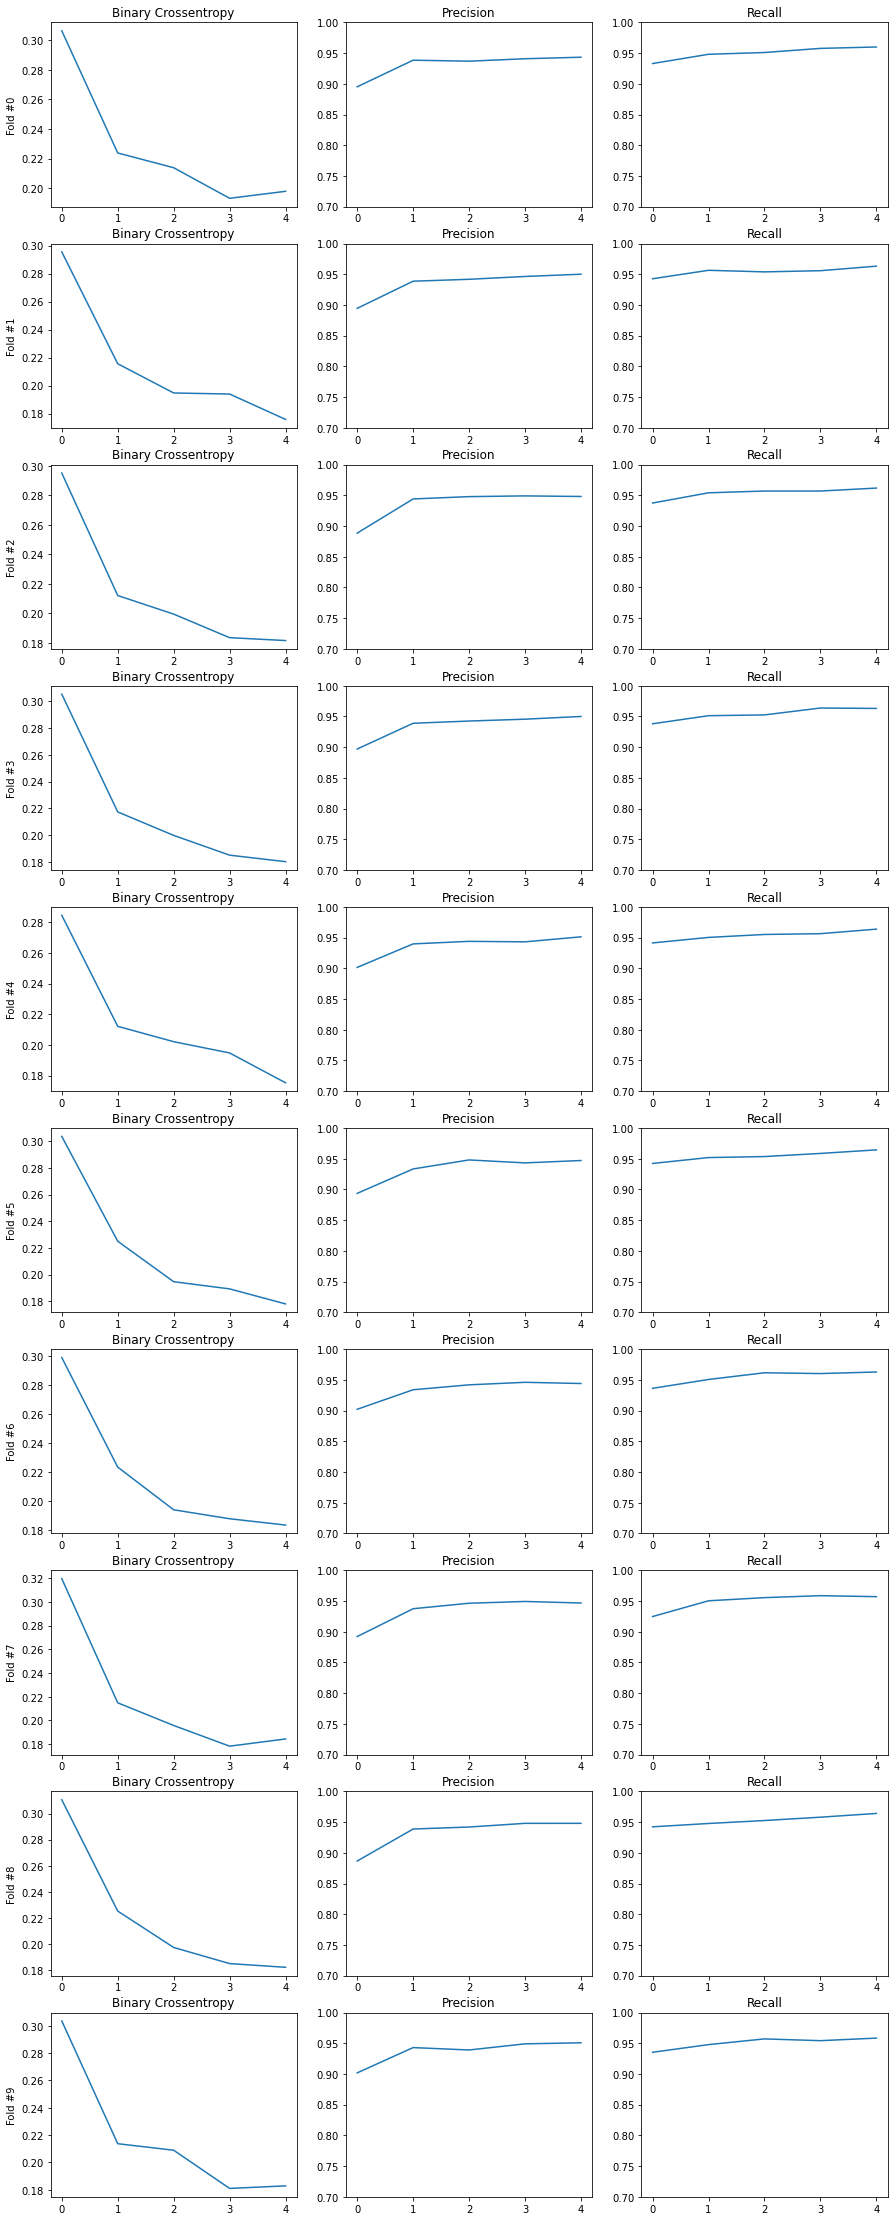

In [124]:
plot_histories(histories8)

In [125]:
histories9, eval_scores9 = mlp(0.000001, metrics)
scores.append(('mlp', 0.000001, eval_scores9))

MLP
L2 Lambda: 1e-06 

Fold 0

Epoch 1/5
133/133 [==============================] - 2s 8ms/step - loss: 0.3688 - precision: 0.8498 - recall: 0.9416 - val_loss: 0.1878 - val_precision: 0.9580 - val_recall: 0.9481
Epoch 2/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2267 - precision: 0.9387 - recall: 0.9464 - val_loss: 0.1925 - val_precision: 0.9294 - val_recall: 0.9712
Epoch 3/5
133/133 [==============================] - 1s 6ms/step - loss: 0.1985 - precision: 0.9405 - recall: 0.9567 - val_loss: 0.1828 - val_precision: 0.9426 - val_recall: 0.9654
Epoch 4/5
133/133 [==============================] - 1s 6ms/step - loss: 0.1815 - precision: 0.9467 - recall: 0.9678 - val_loss: 0.1911 - val_precision: 0.9267 - val_recall: 0.9769
Epoch 5/5
133/133 [==============================] - 1s 6ms/step - loss: 0.1867 - precision: 0.9456 - recall: 0.9567 - val_loss: 0.1679 - val_precision: 0.9562 - val_recall: 0.9573

15/15 [==============================] - 0s 2ms/step - loss: 0.

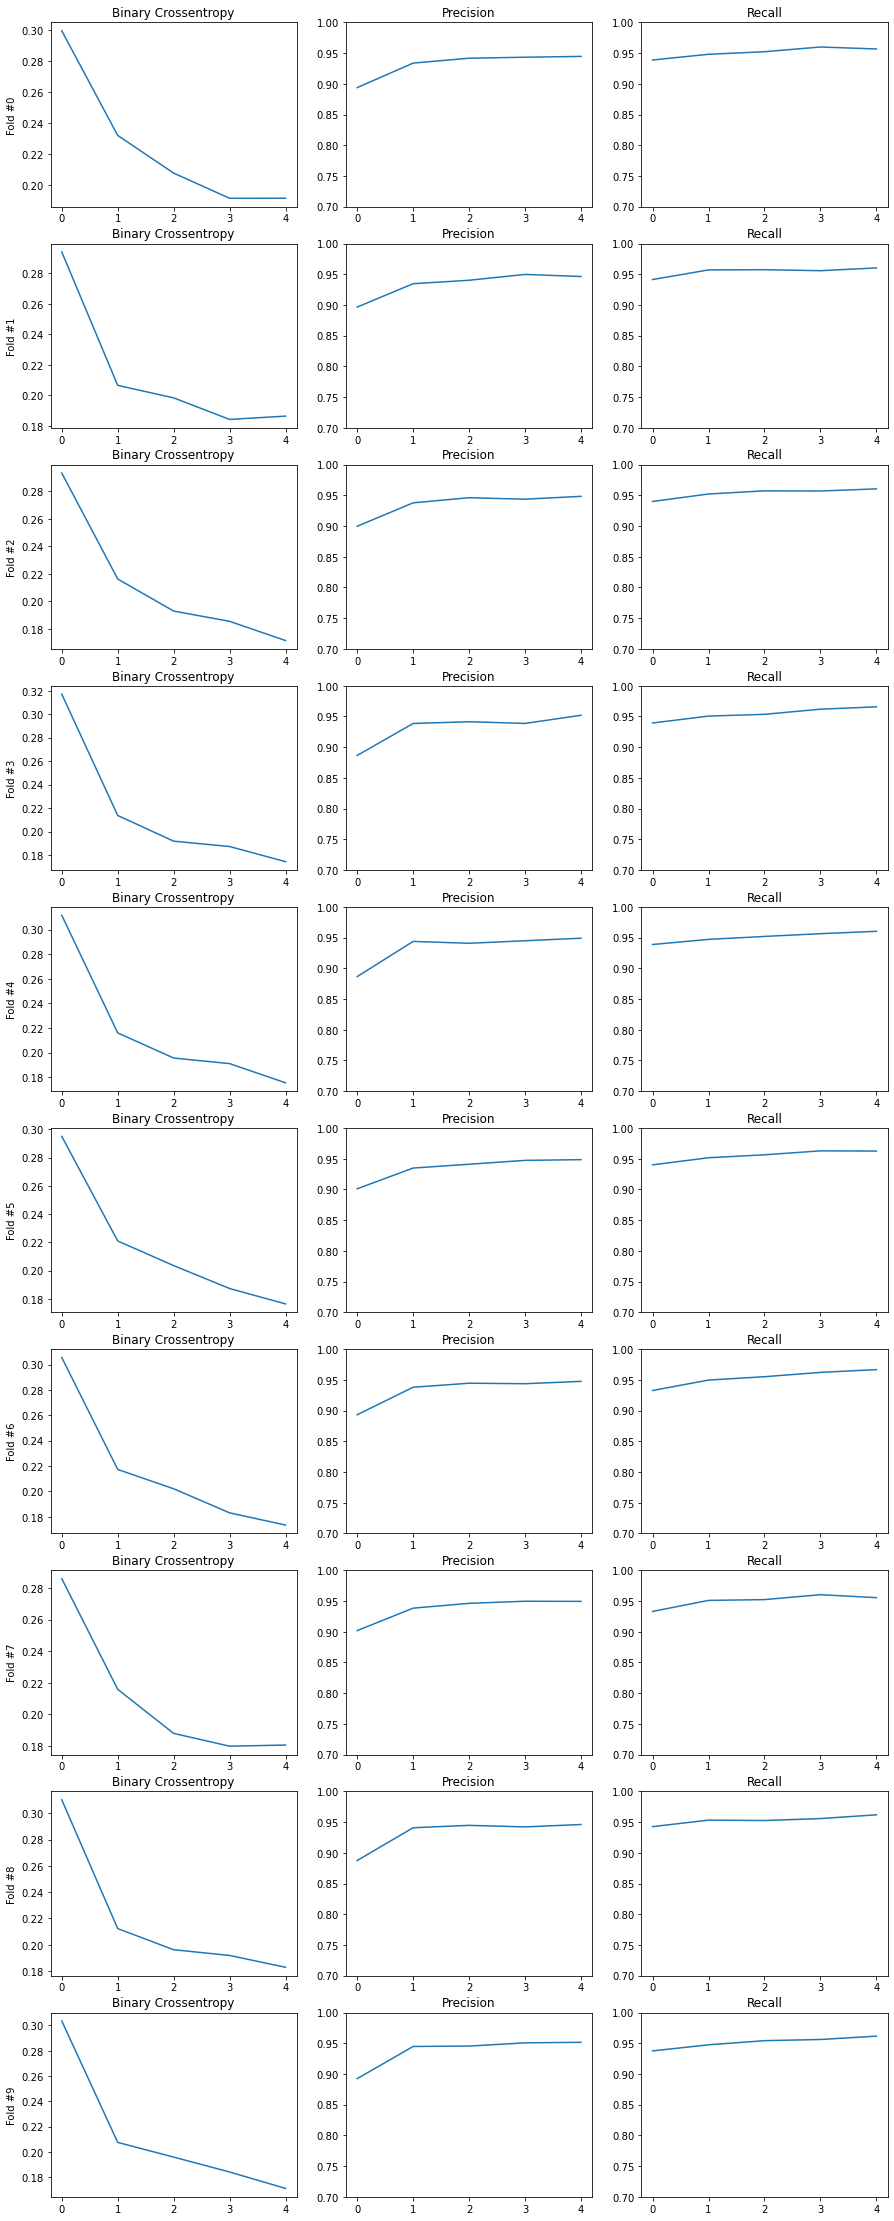

In [126]:
plot_histories(histories9)

<ipython-input-103-a551b930b006>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_splits,3,3*fold+1)
<ipython-input-103-a551b930b006>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_splits,3,3*fold+2)
<ipython-input-103-a551b930b006>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance

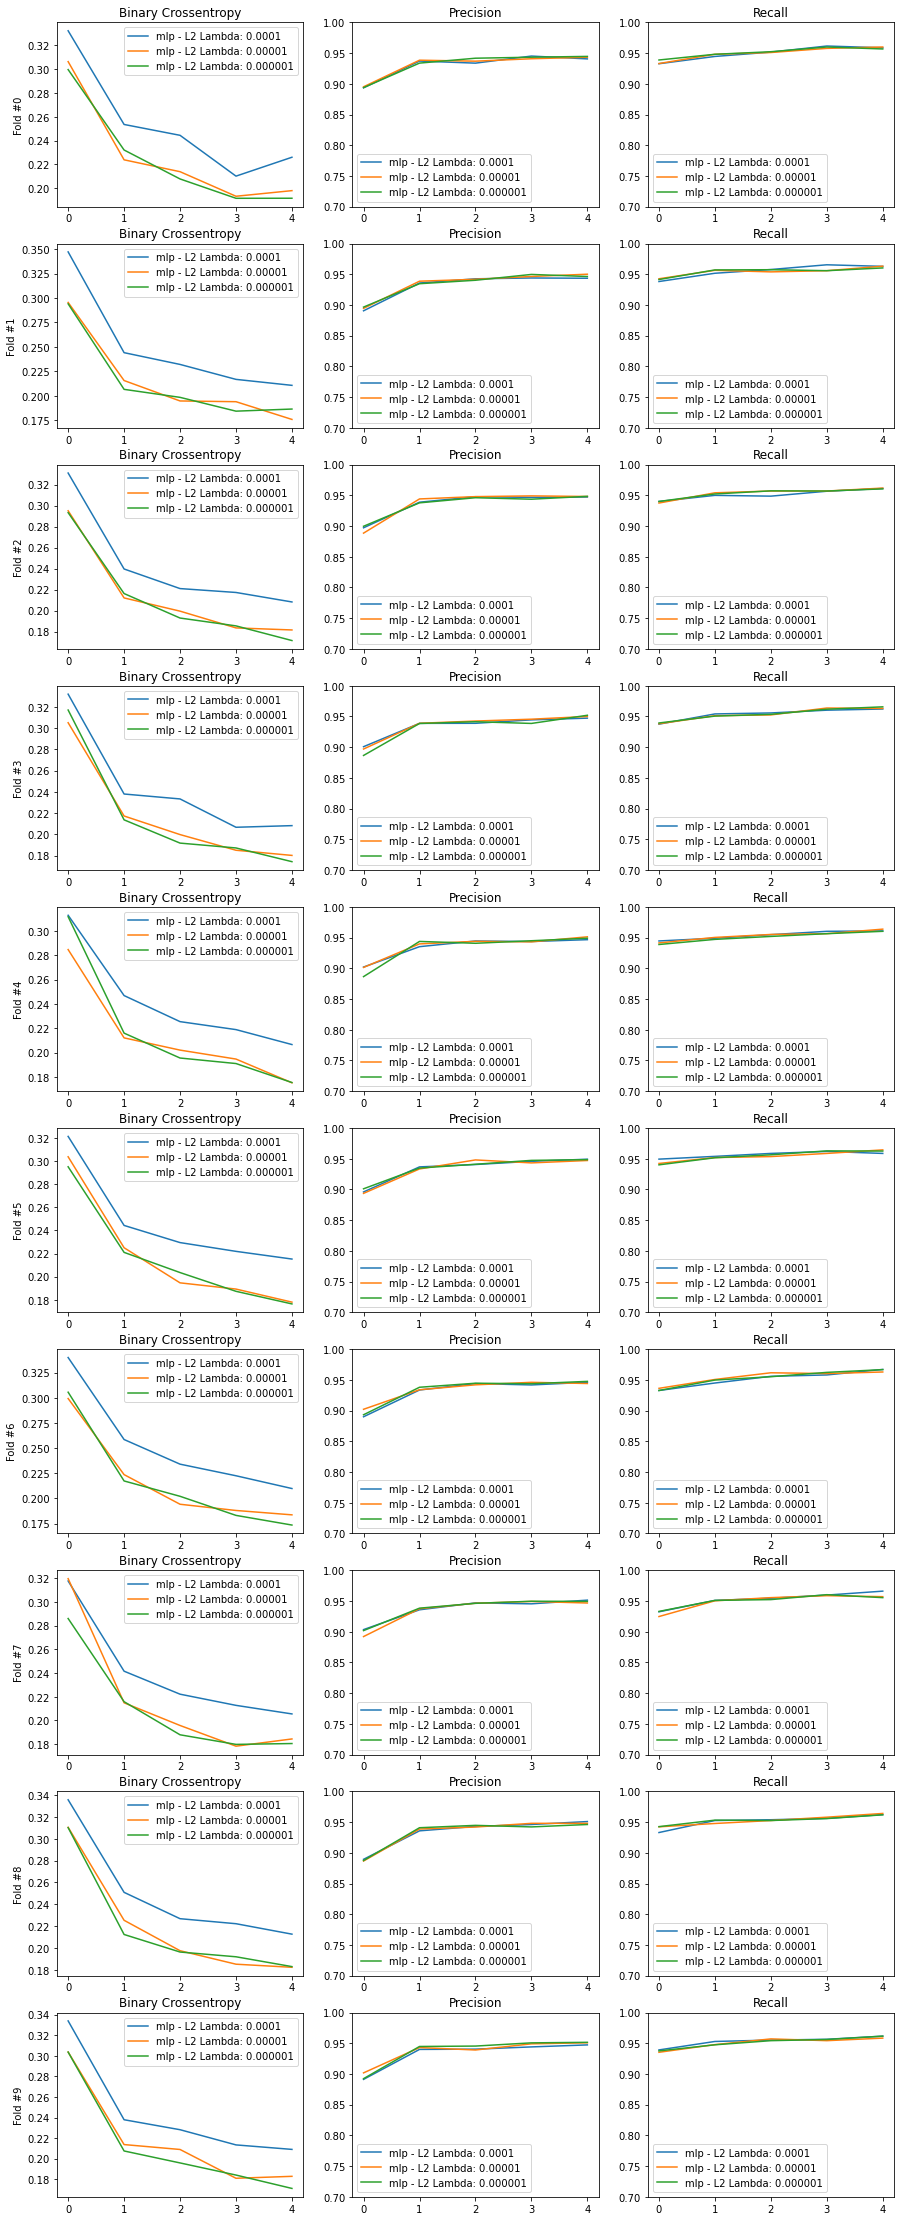

In [127]:
plot_histories2([0,1,2,3,4,5,6,7,8,9], [histories7, histories8, histories9], ['mlp - L2 Lambda: 0.0001', 'mlp - L2 Lambda: 0.00001','mlp - L2 Lambda: 0.000001'])

## Comparison of Models vs MLP

<ipython-input-103-a551b930b006>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_splits,3,3*fold+1)
<ipython-input-103-a551b930b006>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_splits,3,3*fold+2)
<ipython-input-103-a551b930b006>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance

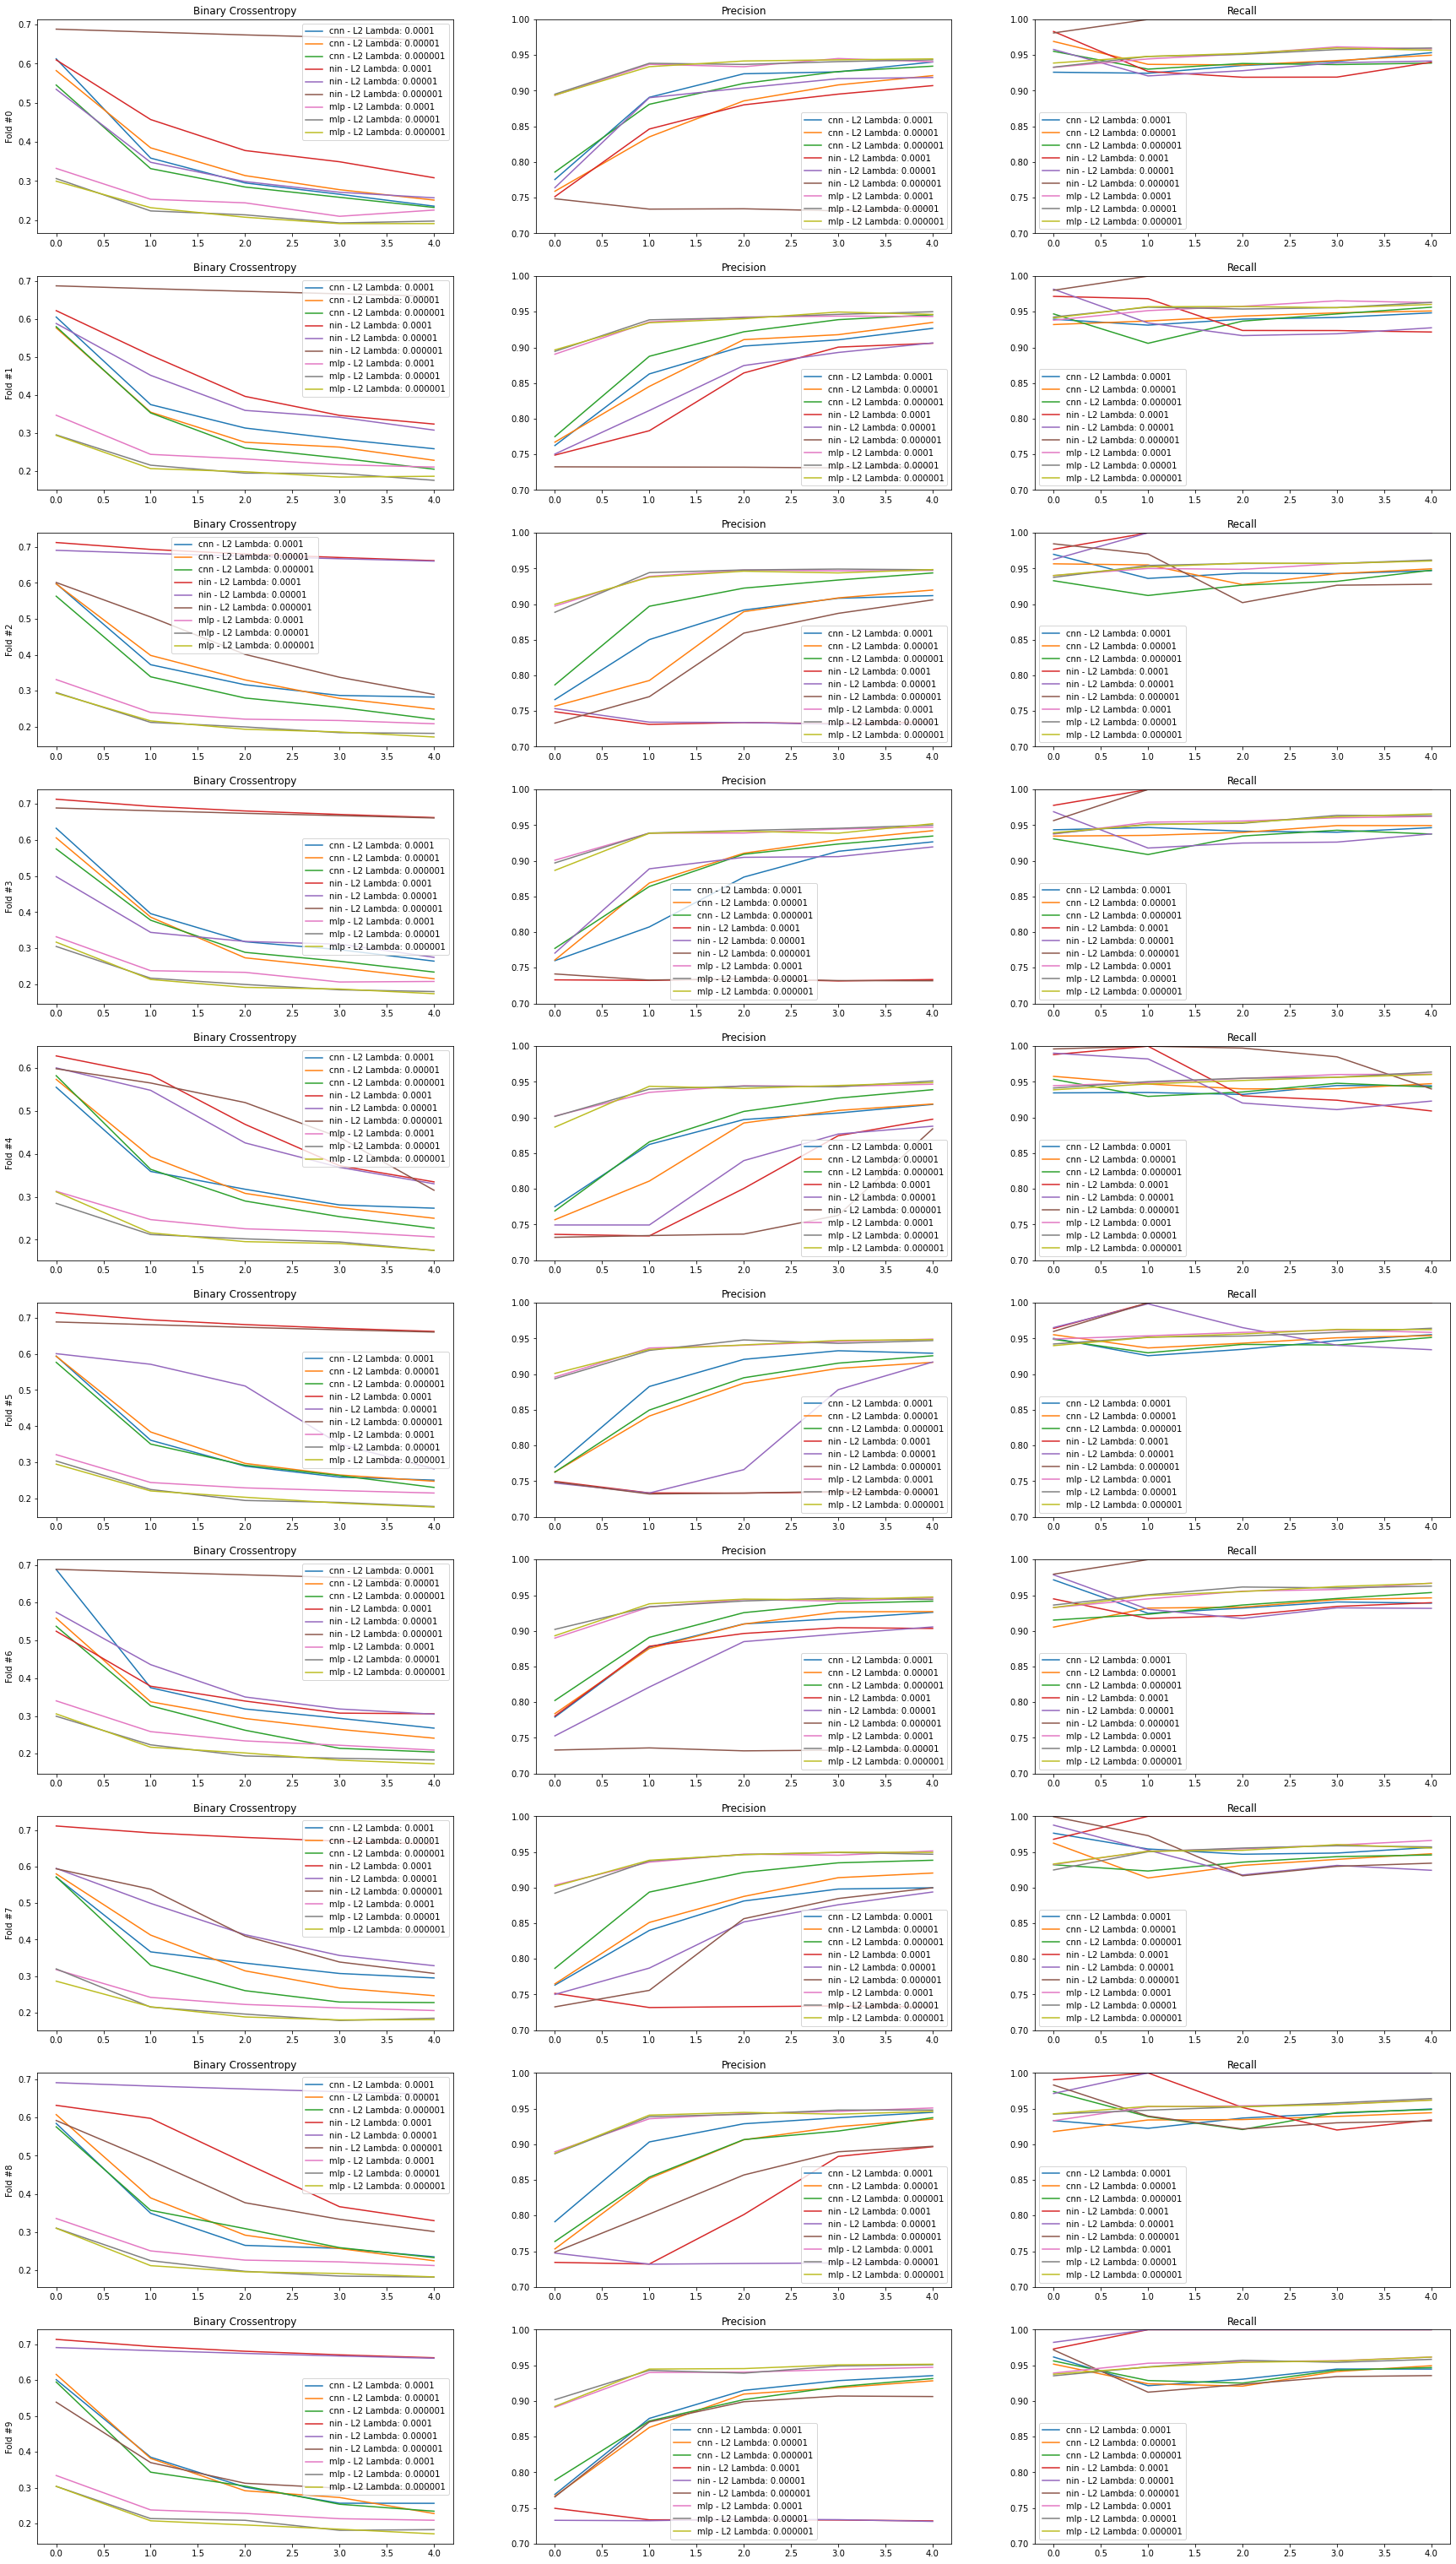

In [128]:
plot_histories2([0,1,2,3,4,5,6,7,8,9], [histories1, histories2, histories3, histories4, histories5, histories6, histories7, histories8, histories9], ['cnn - L2 Lambda: 0.0001', 'cnn - L2 Lambda: 0.00001','cnn - L2 Lambda: 0.000001','nin - L2 Lambda: 0.0001','nin - L2 Lambda: 0.00001','nin - L2 Lambda: 0.000001','mlp - L2 Lambda: 0.0001', 'mlp - L2 Lambda: 0.00001','mlp - L2 Lambda: 0.000001'],dimensions = (30,55))

### Explanation of Comparison of Models vs MLP

## McNemar Test for Models vs MLP

In [160]:
# from sklearn import metrics as mt

# mlp = build_mlp(.0001, metrics)
# y_hat = mlp.predict(X_final)
# #print(y_hat, y_final)
# #print(np.count_nonzero(np.round(y_hat)))
# #print(len(y_hat))

# yhat = np.round(y_hat)

# #print(mt.confusion_matrix(y_final,yhat))
# print(mt.classification_report(y_final,yhat))

# mlp.evaluate(X_final, y_final, verbose=verbose)

from sklearn.metrics import confusion_matrix

bm1 = build_basic_model(.0001, metrics)
bm1_results = bm1.predict(X_final)
bm1_results[bm1_results != 1] = 0
bm1_confusion = confusion_matrix(y_final, bm1_results.flatten()).ravel()

bm2 = build_basic_model(.00001, metrics)
bm2_results = bm2.predict(X_final)
bm2_results[bm2_results != 1] = 0
bm2_confusion = confusion_matrix(y_final, bm2_results.flatten()).ravel()

bm3 = build_basic_model(.000001, metrics)
bm3_results = bm3.predict(X_final)
bm3_results[bm3_results != 1] = 0
bm3_confusion = confusion_matrix(y_final, bm3_results.flatten()).ravel()

nin1 = build_nin_model(.0001, metrics)
nin1_results = nin1.predict(X_final)
nin1_results[nin1_results != 1] = 0
nin1_confusion = confusion_matrix(y_final, nin1_results.flatten()).ravel()

nin2 = build_nin_model(.00001, metrics)
nin2_results = nin2.predict(X_final)
nin2_results[nin2_results != 1] = 0
nin2_confusion = confusion_matrix(y_final, nin2_results.flatten()).ravel()

nin3 = build_nin_model(.000001, metrics)
nin3_results = nin3.predict(X_final)
nin3_results[nin3_results != 1] = 0
nin3_confusion = confusion_matrix(y_final, nin3_results.flatten()).ravel()

mlp1 = build_mlp(.0001, metrics)
mlp1_results = mlp1.predict(X_final)
mlp1_results[mlp1_results != 1] = 0
mlp1_confusion = confusion_matrix(y_final, mlp1_results.flatten()).ravel()

mlp2 = build_mlp(.0001, metrics)
mlp2_results = mlp2.predict(X_final)
mlp2_results[mlp2_results != 1] = 0
mlp2_confusion = confusion_matrix(y_final, mlp2_results.flatten()).ravel()

mlp3 = build_mlp(.0001, metrics)
mlp3_results = mlp3.predict(X_final)
mlp3_results[mlp3_results != 1] = 0
mlp3_confusion = confusion_matrix(y_final, mlp3_results.flatten()).ravel()

In [161]:
confusion_matrix = [
    ['', 'bm1', 'bm2', 'bm3', 'nin1', 'nin2', 'nin3', 'mlp1', 'mlp2', 'mlp3'],
    ['True Negative', bm1_confusion[0], bm2_confusion[0], bm3_confusion[0], nin1_confusion[0], nin2_confusion[0], nin3_confusion[0], mlp1_confusion[0], mlp2_confusion[0], mlp3_confusion[0]],
    ['False Positive', bm1_confusion[1], bm2_confusion[1], bm3_confusion[1], nin1_confusion[1], nin2_confusion[1], nin3_confusion[1], mlp1_confusion[1], mlp2_confusion[1], mlp3_confusion[1]],
    ['False Negative', bm1_confusion[2], bm2_confusion[2], bm3_confusion[2], nin1_confusion[2], nin2_confusion[2], nin3_confusion[2], mlp1_confusion[2], mlp2_confusion[2], mlp3_confusion[2]],
    ['True Positive', bm1_confusion[3], bm2_confusion[3], bm3_confusion[3], nin1_confusion[3], nin2_confusion[3], nin3_confusion[3], mlp1_confusion[3], mlp2_confusion[3], mlp3_confusion[3]],
                   ]
#https://stackoverflow.com/questions/13214809/pretty-print-2d-python-list
s = [[str(e) for e in row] for row in confusion_matrix]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print ('\n'.join(table))

              	bm1	bm2	bm3	nin1	nin2	nin3	mlp1	mlp2	mlp3
True Negative 	315	315	315	315 	315 	315 	315 	315 	315 
False Positive	0  	0  	0  	0   	0   	0   	0   	0   	0   
False Negative	867	867	867	867 	867 	867 	867 	867 	867 
True Positive 	0  	0  	0  	0   	0   	0   	0   	0   	0   


In [163]:
#reate contingency tables

both_correct = [
    ['', 'bm1', 'bm2', 'bm3', 'nin1', 'nin2', 'nin3', 'mlp1', 'mlp2', 'mlp3'],
    ['bm1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['bm2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['bm3', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin3', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp3', 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

first_correct = [
    ['', 'bm1', 'bm2', 'bm3', 'nin1', 'nin2', 'nin3', 'mlp1', 'mlp2', 'mlp3'],
    ['bm1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['bm2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['bm3', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin3', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp3', 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

both_incorrect = [
    ['', 'bm1', 'bm2', 'bm3', 'nin1', 'nin2', 'nin3', 'mlp1', 'mlp2', 'mlp3'],
    ['bm1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['bm2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['bm3', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['nin3', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp1', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp2', 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['mlp3', 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

for basic1, basic2, basic3, net1, net2, net3, multi1, multi2, multi3, y_vals in zip('bm1_results', 'bm2_results', 'bm3_results', 'nin1_results', 'nin2_results', 'nin3_results', 'mlp1_results', 'mlp2_results', 'mlp3_results', 'y_test'):
    if(basic1 == targetVal):
        both_correct[1][1] += 1;
        
        if(basic2 == targetVal):
            both_correct[1][2] += 1;
        else:
            first_correct[1][2] += 1;
            
        if(resnetVal == targetVal):
            both_correct[1][3] += 1;
        else:
            first_correct[1][3] += 1;
            
        if(resnet2Val == targetVal):
            both_correct[1][4] += 1;
        else:
            first_correct[1][4] += 1;
            
        if(mlpVal == targetVal):
            both_correct[1][5] += 1;
        else:
            first_correct[1][5] += 1;
    else:
        both_incorrect[1][1] += 1;
        
        if(cnn2Val != targetVal):
            both_incorrect[1][2] += 1;
            
        if(resnetVal != targetVal):
            both_incorrect[1][3] += 1;
            
        if(resnet2Val != targetVal):
            both_incorrect[1][4] += 1;
            
        if(mlpVal != targetVal):
            both_incorrect[1][5] += 1;
            
    if(cnn2Val == targetVal):
        both_correct[2][2] += 1;
        
        if(cnnVal == targetVal):
            both_correct[2][1] += 1;
        else:
            first_correct[2][1] += 1;
            
        if(resnetVal == targetVal):
            both_correct[2][3] += 1;
        else:
            first_correct[2][3] += 1;
            
        if(resnet2Val == targetVal):
            both_correct[2][4] += 1;
        else:
            first_correct[2][4] += 1;
            
        if(mlpVal == targetVal):
            both_correct[2][5] += 1;
        else:
            first_correct[2][5] += 1;
    else:
        both_incorrect[2][2] += 1;
        
        if(cnnVal != targetVal):
            both_incorrect[2][1] += 1;
            
        if(resnetVal != targetVal):
            both_incorrect[2][3] += 1;
            
        if(resnet2Val != targetVal):
            both_incorrect[2][4] += 1;
            
        if(mlpVal != targetVal):
            both_incorrect[2][5] += 1;
            
    if(resnetVal == targetVal):
        both_correct[3][3] += 1;
        
        if(cnn2Val == targetVal):
            both_correct[3][2] += 1;
        else:
            first_correct[3][2] += 1;
            
        if(cnnVal == targetVal):
            both_correct[3][1] += 1;
        else:
            first_correct[3][1] += 1;
            
        if(resnet2Val == targetVal):
            both_correct[3][4] += 1;
        else:
            first_correct[3][4] += 1;
            
        if(mlpVal == targetVal):
            both_correct[3][5] += 1;
        else:
            first_correct[3][5] += 1;
    else:
        both_incorrect[3][3] += 1;
        
        if(cnn2Val != targetVal):
            both_incorrect[3][2] += 1;
            
        if(cnnVal != targetVal):
            both_incorrect[3][1] += 1;
            
        if(resnet2Val != targetVal):
            both_incorrect[3][4] += 1;
            
        if(mlpVal != targetVal):
            both_incorrect[3][5] += 1;
            
    if(resnet2Val == targetVal):
        both_correct[4][4] += 1;
        
        if(cnn2Val == targetVal):
            both_correct[4][2] += 1;
        else:
            first_correct[4][2] += 1;
            
        if(resnetVal == targetVal):
            both_correct[4][3] += 1;
        else:
            first_correct[4][3] += 1;
            
        if(cnnVal == targetVal):
            both_correct[4][1] += 1;
        else:
            first_correct[4][1] += 1;
            
        if(mlpVal == targetVal):
            both_correct[4][5] += 1;
        else:
            first_correct[4][5] += 1;
    else:
        both_incorrect[4][4] += 1;
        
        if(cnn2Val != targetVal):
            both_incorrect[4][4] += 1;
            
        if(resnetVal != targetVal):
            both_incorrect[4][4] += 1;
            
        if(cnnVal != targetVal):
            both_incorrect[4][1] += 1;
            
        if(mlpVal != targetVal):
            both_incorrect[4][5] += 1;
            
    if(mlpVal == targetVal):
        both_correct[5][5] += 1;
        
        if(cnn2Val == targetVal):
            both_correct[5][2] += 1;
        else:
            first_correct[5][2] += 1;
            
        if(resnetVal == targetVal):
            both_correct[5][3] += 1;
        else:
            first_correct[5][3] += 1;
            
        if(resnet2Val == targetVal):
            both_correct[5][4] += 1;
        else:
            first_correct[5][4] += 1;
            
        if(cnnVal == targetVal):
            both_correct[5][1] += 1;
        else:
            first_correct[5][1] += 1;
    else:
        both_correct[5][5] += 1;
        
        if(cnn2Val != targetVal):
            both_incorrect[5][2] += 1;
            
        if(resnetVal != targetVal):
            both_incorrect[5][3] += 1;
            
        if(resnet2Val != targetVal):
            both_incorrect[5][4] += 1;
            
        if(cnnVal != targetVal):
            both_incorrect[5][1] += 1;

print('both correct')
s = [[str(e) for e in row] for row in both_correct]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print ('\n'.join(table))

print('\nboth incorrect')
s = [[str(e) for e in row] for row in both_incorrect]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print ('\n'.join(table))

print('\nfirst correct')
s = [[str(e) for e in row] for row in first_correct]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print ('\n'.join(table))

NameError: name 'cnn_results' is not defined

In [ ]:
try:
    print('cnn and cnn2')
    b = contingency_table_first_correct[1][2]
    c = contingency_table_first_correct[2][1]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('cnn and cnn2 are too similar \n')

try:
    print('cnn and resnet')
    b = contingency_table_first_correct[1][3]
    c = contingency_table_first_correct[3][1]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('cnn and resnet are too similar \n')

try:
    print('cnn and resnet2')
    b = contingency_table_first_correct[1][4]
    c = contingency_table_first_correct[4][1]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('cnn and resnet2 are too similar \n')

try:
    print('cnn and mlp')
    b = contingency_table_first_correct[1][5]
    c = contingency_table_first_correct[5][1]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('cnn and mlp are too similar \n')
    

try:
    print('cnn2 and resnet')
    b = contingency_table_first_correct[2][3]
    c = contingency_table_first_correct[3][2]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('cnn2 and resnet are too similar \n')

try:
    print('cnn2 and resnet2')
    b = contingency_table_first_correct[2][4]
    c = contingency_table_first_correct[4][2]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('cnn2 and resnet2 are too similar \n')

try:
    print('cnn2 and mlp')
    b = contingency_table_first_correct[2][5]
    c = contingency_table_first_correct[5][2]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('cnn2 and mlp are too similar \n')

try:
    print('resnet and resnet2')
    b = contingency_table_first_correct[3][4]
    c = contingency_table_first_correct[4][3]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('resnet and resnet2 are too similar \n')

try:
    print('resnet and mlp')
    b = contingency_table_first_correct[3][5]
    c = contingency_table_first_correct[5][3]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('resnet and mlp are too similar \n')

try:
    print('resnet2 and mlp')
    b = contingency_table_first_correct[4][5]
    c = contingency_table_first_correct[5][4]
    print(((b-c)**2) / (b+c))
    print()
except:
    print('resnet2 and mlp are too similar \n')

In [ ]:
def roc(model):
    kfold = StratifiedKFold(n_splits=4).split(train_images, train_targets)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(kfold):
        probas = model.predict(train_images[test])

        perclass_mean_tpr = 0.0
        roc_auc = 0
        
        fpr, tpr, thresholds = roc_curve(train_targets[test],
                                         probas)
        perclass_mean_tpr += np.interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

        mean_tpr += perclass_mean_tpr
        plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [ ]:
roc(mlp)
roc(resnet)

### Explanation of McNemar Test Results for Models vs MLP

## Exceptional Work (1 pt)

- You have free reign to provide additional analyses. 
- One idea (<b>required for 7000 level students</b>): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 